In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
import datetime as dt
import urllib
import requests as req
from bs4 import BeautifulSoup
import json

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Main dataset viewing

In [8]:
mbti = pd.read_csv('./mbti_1.csv')
mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [9]:
mbti['post_list'] = mbti.posts.apply(lambda x: x.split('|||'))
mbti.head()

,type,posts,post_list
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ..."
1,ENTP,'I'm finding the lack of me in these posts ver...,['I'm finding the lack of me in these posts ve...
2,INTP,'Good one _____ https://www.youtube.com/wat...,['Good one _____ https://www.youtube.com/wa...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","['Dear INTP, I enjoyed our conversation the ..."
4,ENTJ,'You're fired.|||That's another silly misconce...,"['You're fired., That's another silly misconce..."


In [10]:
mbti.shape

(8675, 3)

In [12]:
def funkfunk(x):
    """
    RUN ONLY ONCE
    Removes the pesky single quote sign that somehow still remains after splitting them into a list.
    It technically returns nothing.
    """
    if re.match("'",x[0]):
        x[0] = x[0][1:]
    if re.match("'",x[-1][::-1]):
        x[-1] = x[-1][:-1]
    

mbti['post_list'].apply(funkfunk)

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
8645    None
8646    None
8647    None
8648    None
8649    None
8650    None
8651    None
8652    None
8653    None
8654    None
8655    None
8656    None
8657    None
8658    None
8659    None
8660    None
8661    None
8662    None
8663    None
8664    None
8665    None
8666    None
8667    None
8668    None
8669    None
8670    None
8671    None
8672    None
8673    None
8674    None
Name: post_list, Length: 8675, dtype: object

In [14]:
mbti['post_list'][0]

['http://www.youtube.com/watch?v=qsXHcwe3krw',
 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
 'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
 'What has been the most life-changing experience in your life?',
 'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
 'May the PerC Experience immerse you.',
 'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
 "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
 '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-hom

In [103]:
mbti.isnull().sum()

type         0
posts        0
post_list    0
dtype: int64

In [104]:
mbti.dtypes

type         object
posts        object
post_list    object
dtype: object

In [105]:
#Create new dataframe to keep and generate features
mbtilist = pd.DataFrame(mbti['post_list'])
mbtilist.head()

,post_list
0,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h..."
1,[I'm finding the lack of me in these posts ver...
2,[Good one _____ https://www.youtube.com/wat...
3,"[Dear INTP, I enjoyed our conversation the o..."
4,"[You're fired., That's another silly misconcep..."


In [106]:
#test data using part
part = mbtilist.iloc[0:5,:]
part.head()

,post_list
0,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h..."
1,[I'm finding the lack of me in these posts ver...
2,[Good one _____ https://www.youtube.com/wat...
3,"[Dear INTP, I enjoyed our conversation the o..."
4,"[You're fired., That's another silly misconcep..."


### 1st iteration - Perform link extraction

In [107]:
def extractions(x, string):
    """
    Input:
    x = A list containing sentences
    string = regular expression that will match each word
    
    Output:
    lis = List of weblinks
    lis2 = List of 'words only' posts

    How the function works:

    While iterating per item (containing a sentence) in a list, the sentence is split into individual words separated by spaces.
    An input string containing a regular expression will be passed inside as part of the function.
    Iterating through each word, if the word matches the regular expression, it will be added into the new list.
    The new list will hence be collecting all the re matched words that came from the input list with the chunk of sentences.
    This function returns the new list.
    
    2nd update: I also needed a 'words only' list, and since getting the words only is just the 'else' process of getting
    links...
    """
    lis=[]
    lis2 = []
    for line in x[0]:
        lin = line.split()
        sstring = re.compile(string, flags=re.M)
        lis_temp =[]
        for l in lin:
            if sstring.search(l):
                lis.append(sstring.search(l).group(0))
            else:
                lis_temp.append(l)
        lis_string = ' '.join(lis_temp)
        lis2.append(lis_string)
    return lis, lis2

In [109]:
# item_x = part.apply(extractions, string='http.*',axis=1)
# part['weblink'] = [x[0] for x in item_x]
# part['words_only'] = [x[1] for x in item_x]

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
#Compile list of links into main MBTI dataframe from successful code run
#When functions have failed me in multiple assignments I have to take things into my own hands (via list compre)
item_x = mbtilist.apply(extractions, string='http.*',axis=1)
mbtilist['weblink'] = [x[0] for x in item_x]
mbtilist['words_only'] = [x[1] for x in item_x]

In [112]:
def onelvl_extract(x, string):
    """
    Input:
    x = A list of words
    string = regular expression in string form

    How the function works:

    Iterating through each word, if the word matches the regular expression, it will be added into the new list.
    The new list will hence be collecting all the re matched words that came from the input list with the chunk of sentences.
    This function returns the new list.
    """

    lis=[]
    sstring = re.compile(string, flags=re.M)
    for line in x:
        if sstring.search(line):
            lis.append(sstring.search(line).group(0))
    return lis

In [17]:
# #reinitialize part
# part = mbtilist.iloc[0:5,:]
# part.head()

In [18]:
# partchunk1 = ''.join(part.weblink.apply(onelvl_extract, string='http.*(?=https?:)')[1])

In [19]:
# partchunk1

In [20]:
# wholechunk1 = part.weblink[1]

In [21]:
# wholechunk1

In [22]:
# littlechunk1 = ''.join([i for i in wholechunk1 if partchunk1 in i])

In [23]:
# print littlechunk1

In [24]:
# littlechunk1[len(partchunk1):]

In [113]:
def eliminate_httpdup(x):
    
    """
    Input = A list containing URLs

    How this function works:
    
    Some URLs that have been extracted happen to be concatenated successively without any separator in between.
    For example, a URL containing the following 'https://www.youtu.be/blahblahhttp://neninenipoopoo...'
    The function iterates through the URLs, identify the URL of the above kind then separates them.
    After separation, the concatenated string is then removed and the two separated URLs are added into the list.
    
    End result: 'https://www.youtu.be/blahblah' 'http://neninenipoopoo...'
    
    Additionally, there are also URLs which are incomplete i.e. 'http://',
    we will check both of the processed ones and drop them accordingly.
    
    This function returns the new list after the processing.
    Unfortunately there may exist multiple (more than 2) concatenated URLs and I still do not yet have the brain to process
    how to do that in one go, so this particular function got to be run multiple times.
    """
    
    wholechunk = list(x) #Must indicate as list, otherwise whatever happens to wholechunk will also happen to x :X
    for line in x:
        if re.match('http.*(?=https?:)', line):
            partchunk = re.match('http.*(?=https?:)', line).group(0)
            secondchunk = line[len(partchunk):]
            wholechunk.remove(line)
            if re.match('https?://.*\.[\w\d].*', partchunk):
                wholechunk.append(partchunk)
            if re.match('https?://.*\.[\w\d].*', secondchunk):
                wholechunk.append(secondchunk)
    return wholechunk
            

In [114]:
def sumall(x):
    return sum(x.apply(len))

In [27]:
# part['weblink'].apply(eliminate_httpdup)

In [28]:
# part['weblink1'] = part['weblink'].apply(eliminate_httpdup)

In [29]:
# #They are similar because its inplace and I don't know how!!!
# #Update: I think I fixed it!
# sumall(part['weblink'])

In [30]:
# sumall(part['weblink1'])

In [31]:
# sumall(mbtilist['weblink'])

In [115]:
#Its inplace by default, damnit
#Update: not anymore!

mbtilist['weblink1'] = mbtilist['weblink'].apply(eliminate_httpdup)
a = 0
count = 0
while a != sumall(mbtilist['weblink1']):
    a = sumall(mbtilist['weblink1'])
    print "No. links:", a
    mbtilist['weblink1'] = mbtilist['weblink1'].apply(eliminate_httpdup)
    count += 1
print count

No. links: 28556
No. links: 28569
No. links: 28573
No. links: 28575
No. links: 28576
5


### Extract website type

In [34]:
# #reinitialize part
# part = mbtilist.iloc[0:50,:]
# part.head()

In [35]:
# part['image'] = part['weblink1'].apply(onelvl_extract, string=r'.*\.(jpg|png|jpeg|gif).*|.*img.*|.*image.*')
# for partie in part['image']:
#     print "_________________________________________________________________________"
#     for i in partie:
#         print i
        

In [36]:
# for partie in part['weblink1']:
#     print "_________________________________________________________________________"
#     for i in partie:
#         print i

In [37]:
# #Try getting only the base url
# for partie in part['weblink1'].apply(onelvl_extract, string=r'(?=https?://)(.*)(?=/.*)')[0]:
#     print partie

In [38]:
# #Get videos
# part['video_link'] = part['weblink1'].apply(onelvl_extract, string=r'https?://.*youtu.*|http.*vimeo.*')

In [116]:
mbtilist.head()

,post_list,weblink,words_only,weblink1
0,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...","[http://www.youtube.com/watch?v=qsXHcwe3krw, h...","[, , enfp and intj moments sportscenter not to...","[http://www.youtube.com/watch?v=qsXHcwe3krw, h..."
1,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...
2,[Good one _____ https://www.youtube.com/wat...,"[https://www.youtube.com/watch?v=fHiGbolFFGw, ...","[Good one _____, Of course, to which I say I k...","[https://www.youtube.com/watch?v=fHiGbolFFGw, ..."
3,"[Dear INTP, I enjoyed our conversation the o...","[https://www.youtube.com/watch?v=uelHwf8o7_U, ...","[Dear INTP, I enjoyed our conversation the oth...","[https://www.youtube.com/watch?v=uelHwf8o7_U, ..."
4,"[You're fired., That's another silly misconcep...","[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...","[You're fired., That's another silly misconcep...","[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ..."


In [117]:
#Get rest of the links
def happyfunc(x):
    """
    x: DataFrame row containing the total weblink plus the video and image link list
    This function removes the video and image urls from the weblink list and returns a new list.    
    """
    
    newlist = list(x[3])
    if x[4]:
        for img in x[4]:
            try:
                newlist.remove(img)
            except:
                print "WHUT"
                print img
                continue
    if x[5]:
        for you in x[5]:
            try:
                newlist.remove(you)
            except:
                print "WHUT"
                print you
                continue
    return newlist

In [118]:
# part['otherlink'] = part.apply(happyfunc, axis=1)

In [119]:
# for line in part['otherlink']:
#     print "______________________________________________"
#     for i in line:
#         print i

###### Get counts

In [120]:
# part['n_video'] = part['video_link'].apply(len)
# part['n_links'] = part['weblink1'].apply(len)
# part['n_image'] = part['image'].apply(len)

In [121]:
# part.head()

###### Videos

In [132]:
#Get youtube titles
def get_title(url):
    """
    url: URL of course!
    Fun times ahead!
    
    This function will specially take in the video URLs and return the title
    
    """
    try:
        html = req.get(url, timeout=1).text
        soup = BeautifulSoup(html, 'html.parser')
    except:
        return None
    title=None
    if "youtu" in url:
        title = re.match(r'<.+>(.*) - YouTube.*<.+>', str(soup.title))
    elif "vimeo" in url:
        title = re.match(r'<.+>(.*)<.+>', str(soup.h1))
    if title:
        print title.group(1)
        return title.group(1)
    else:
        return None
    

def insertlist(x):
    """
    Ok this function simply iterates through a list and applies the function to each link, then append to a new list
    if not None.
    """
    newlist=[]
    for url in x:
        y = get_title(url)
        if y is not None:
            newlist.append(y)
    return newlist

In [45]:
# part['video_title'] = part['video_link'].apply(insertlist)

In [46]:
#Classify other websites
# webclassifier = pd.read_csv('webcat.csv', header=None, names=['number','webpage','category'])
# webclassifier.head()

In [47]:
#webclassifier.shape

In [48]:
#webclassifier.isnull().sum()

In [49]:
#webclassifier.dropna(inplace=True)

In [50]:
#webclassifier.isnull().sum()

In [51]:
#webclassifier['category'].value_counts()

In [52]:
# def matchkeyword(x):
#     try:
#         worde =  re.match(r'.*www.facebook.*',str(x))
#     except:
#         return None
#     if worde:
#         print worde.group(0)
#     else:
#         return None

I'll try that another time.

In [53]:
#Other features to come soon

###### Images

In [54]:
#Still figuring out the google part, stay tuned!

##### Run webpage code in mbtilist

In [123]:
mbtilist['image'] = mbtilist['weblink1'].apply(onelvl_extract, string=r'.*\.(jpg|png|jpeg|gif).*|.*img.*|.*image.*')

In [124]:
mbtilist['video_link'] = mbtilist['weblink1'].apply(onelvl_extract, string=r'https?://.*youtu.*|http.*vimeo.*')

In [125]:
mbtilist['otherlink'] = mbtilist.apply(happyfunc, axis=1)

WHUT
http://b.vimeocdn.com/ps/187/573/1875738_300.jpg
WHUT
https://www.youtube.com/watch?v=eimgRedLkkU


In [126]:
mbtilist['n_video'] = mbtilist['video_link'].apply(len)
mbtilist['n_links'] = mbtilist['weblink1'].apply(len)
mbtilist['n_image'] = mbtilist['image'].apply(len)
mbtilist['n_otherlink'] = mbtilist['n_links']-mbtilist['n_image']-mbtilist['n_video']

In [133]:
#This code will take a LOOOOOOOOONGGGG while
mbtilist['video_title'] = mbtilist['video_link'].apply(insertlist)

FLYING IN MY PJs - [Living In Alaska 256]
ENFP and INTJ Morning Moment
ESPN SportsCenter's Not Top Ten - 12-06-13
Jinkis - A Thousand Miles Away (Instrumental Mix) (Melodic Dubstep)
TRON GFX Portal Climax
Paramore - Still Into You Live From MTV
Startle The Heavens - The summer air lingers
Handshake Confusion
Lucksmyth - Rooks
Survivor: Gabon - Immunity Challenge: Lake Log Jam
A Trip Through Time: 6 Years in 14 minutes (2005-2011) (420 Friendly)
Motion City Soundtrack - My Favorite Accident
Jermaine Dupri - Welcome To Atlanta ft. Ludacris
Radiohead - Paranoid Android
Океан Ельзи - Стріляй (official video)
Eminem - Love The Way You Lie ft. Rihanna
Royksopp What Else is There? w/lyrics
Yung Gud - Hello (Ft. Yemi)
Verbatim: What Is a Photocopier? | Op-Docs
How To Tell if You're a Basic Bitch
Kelly Clarkson - Piece By Piece (American Idol The Farewell Season)
Árstíðir - Heyr himna smiður (Icelandic hymn) in train station
Janis Joplin - Ball and Chain (sensational performance at Monterey)
Br

Amazing Ways Mankind Has Respected The Natural World
FIX IT 2016 “Healthcare at the Tipping Point”
Cassini Burns into Saturn After Grand Finale | Out There
The US Capitol dome has a secret stairway — here's what it's like inside
Apple iPhone X first look
Kim Jong Il Announces Plan To Bring Moon To North Korea
Say Anything (1989)
Supernatural - 200 - Carry on my Wayward Son [HD]
【PV】 spending all my time -　Perfume
YOKO SHIMOMURA DRAMMATICA 13 - City of Flickering Destruction [Seiken Densetsu Legend of Mana]
kyoteizinc (video mix)
Alex Morph - Walk The Edge
[Live] Kokia - Chouwa oto ~with reflection~ [Bataclan 2007]
darcia &amp; hamona
Floyd Mayweather Jr Master of Defense
Georges St-Pierre Responds to Nick Diaz, Cesar Gracie
Bruce Willis - Late Show - 2010.02.01 (Part 2)
Brad's Story: A 12 year-old with ADHD
Radio  Free Zerg
Billy Joel - And So It Goes
Tom Scott - Today
Quantic - Archipelago
【C80】 東方 Metalcore - Sleepless Due to the Night - 赤あんこうヴァージョン
【東方Vocal】 EastNewSound - intense
東

Ne-Yo- So You Can Cry (WITH LYRICS)
Phoenix - If I Ever Feel Better Lyrics
Family Feud "September"
The Ultimate Insult - May God Have Mercy On Your Soul - Billy Madison  (Academic Decathlon)
Enya - Orinoco Flow (video)
もののけ姫 - インディアンフルート,Eagle Bone Whistle-Princess MONONOKE-
Ray Charles - Georgia On My Mind (The Orginal Song From The Albom)
Bo Burnham - Can't Handle This (Kanye Rant) - MAKE HAPPY Netflix [HD]
The Antlers - I Don't Want Love (Peter's Version)
J Cole - Wet Dreams (2014 Forest Hills Drive)
Sword of Fury - Final Fantasy IX Music Extended
Radioactive-Imagine Dragons (Lyrics)
Run This Town-Jay-Z Ft. Kanye West &amp; Rihanna-Lyrics
Lost Woods Dubstep Remix - Ephixa (Download at www.ephixa.com Zelda Step)
Green Day: "Boulevard Of Broken Dreams" - [Official Video]
Run This Town-Jay-Z Ft. Kanye West &amp; Rihanna-Lyrics
Iron Man 3 - 'Imagine Dragons - Ready Aim Fire' (1080p HD) Hereos Fall Soundtrack
Sweet Dreams - Steve Angello Remix
Harvard Sailing Team - Boys Will Be Girls
Ha

The Cramps - Psychotic Reaction
Fall Out Boy - Beat It (MTV Version) ft. John Mayer
Hotel California Punk cover, who is it?
Cramps - Route 66
Goldfinger - 99 Red Balloons
Dr. John - Right Place Wrong Time
ZZ Top - I Gotsta Get Paid
ZZ Top - Thug.
Led Zeppelin - Immigrant Song (Live Video)
Led Zeppelin - Over the Hills and Far Away (promo)
Mrs Robinson - Pennywise
Pennywise - Surfin' USA ( Beach Boys Punk Cover )
primal scream 96 tears
Robert Plant | 'Tall Cool One' | Official Music Video
Cat Power - Sea Of Love
Bobby Fuller Four sing Little Annie Lou
Bobby Fuller Four - The Lonely Dragster
The Outsiders - Time Won´t Let Me  (1966)
The Human Beinz - Nobody But Me (with guitar chord intro) - [STEREO]
Billy Joel - All Shook Up (Audio)
Jailhouse Rock (Remastered Version)
The Stranglers - All Day and All of the Night
The Stranglers - Walk On By
BROWNSVILLE STATION -  Barefootin (1973)
Sweet Jane
Gov't Mule with Marcus King at Red Rocks 8/19/17  Whipping Post
Gov't Mule - "Money" (Pink Floyd

Mega Man Battle Network 3 OST - T23: Shine in the Dark (Secret Area)
Yugi Moto vs Seto Kaiba The Dark Side of Dimensions Duel 2016 EPIC DUEL TIME!!!
SSBWiiU Battles: Mega Man Vs Proto Man
Ace Attorney: All Objection! Themes 2016
Tekken 5: Hwoarang Prologue and Epilogue
Tekken 5: Hwoarang Story Compilation
Bruce Lee vs O'hara - Enter the Dragon
Naruto - Naruto vs Sasuke Final Battle -Full Fight-
FF7 Aeris Death Scene
Link VS Cloud (Zelda VS Final Fantasy) | DEATH BATTLE!
The Legend of Zelda: Breath of the Wild - Nintendo Switch Presentation 2017 Trailer
Zelda's Lullaby 10 Hours - Zelda Ocarina of Time
Let's Play The Legend of Zelda Ocarina of Time 3DS - FINALE: Ganon's Castle, Final Boss, Ending OoT
Legend of Zelda: Ocarina of Time - Final Boss: Ganon [1080P]
Shin Megami Tensei Digital Devil Saga 2 Opening
Shin Megami Tensei Digital Devil Saga 2 - Ending
Shin Megami Tensei Nocturne Intro
Shin Megami Tensei: Nocturne - True Demon Ending Final Bosses
Shin Megami Tensei: Digital Devil Saga

Brass Eye Episode 2 Drugs Part 3
Stafrænn Hákon  -  P - Rofi
Beastie Boys- Ricky's Theme ao vivo
Eminem Going Through Changes
Eminem - Mockingbird
WORLD'S FASTEST CLAPPER (802 claps in 1 minute)
Muse perform Madness - Later... with Jools Holland - BBC Two
Elvis Presley -  Jailhouse Rock (HD) Best Quality
Life is Strange Soundtrack - To All Of You by Syd Matters
Haikaiss - RAP LORD part. Jonas Bento (VIDEOCLIPE OFICIAL)
Gorillaz - Let Me Out (Official Audio)
Oomph! - Labyrinth
The Cure - Friday I'm In Love
Frühling in Paris - Rammstein
Lights - And Counting
The Saturdays - What Are You Waiting For?
Dove Real Beauty Sketches  - Extended version
Punch Brothers - This is the Song
"Danny's Song"   Loggins and Messina
Kesha - Cannibal
Mickey Avalon - Mr. Right
Jakewolf I Like Blondes
Deee Lite - Groove is in the Heart (Music Video)
One Direction - What Makes You Beautiful
Nyan Cat [original]
Enon - Natural Disasters
'Long, stabby thing'
Porter Robinson - Flicker (Official Video)
Wilkinson - 

How Soon Is Now? (2011 Remastered Version)
Katzenjammer - A Bar In Amsterdam [Official Music Video]
Glass Animals - Black Mambo
Van Life | Alex Honnold
Vaccination Scar - In Between Evolution - The Tragically Hip
Art
Next - Butta Love
The Vagina Lady
Panic! At The Disco: That Green Gentleman [OFFICIAL VIDEO]
Phantom of the Opera 25th Edition_Past The Point of No Return (full scene)
GTA IV Carmageddon gone Yakety
Foo Fighters - Everlong
Kashiwa Daisuke - Stella
world's end girlfriend「春日狂想」(Instrumental)
Death Metal Chicken
Maroon 5 - Moves Like Jagger ft. Christina Aguilera
Sia - Be Good To Me
フリクリ(FLCL)　ED
Dennou Coil - Prism (Full)
Oprah Winfrey's 2008 Stanford Commencement Address
Bill Evans "Peace Piece"
Richard Feynman on God
XX - Intro
Ep 106 Heckler YOUTUBE
sigur ros - untitled #1 (vaka)
notwist - consequence
Ted Fight Scene
Ted The Movie: Thunder Buddy Song (ORIGINAL)
The Simpsons - Ralph For President
System Of A Down - This Cocaine Makes Me Feel ... #06
Symphony X   Paradise L

getting inside ( second try )
Eminem - When I'm Gone (Steven Lamb Bootleg) [FREE DOWNLOAD]
anathema - twenty one pilots // lyrics
Gabrielle Aplin - The Power of Love
Twenty One Pilots Forest Lyrics
Tom Odell - Can't Pretend (at Dean Street Studios)
Bjork - Human behaviour
Twenty One Pilots - A Car, A Torch, A Death
Tove Lo - Habits (Stay High)
ODESZA - It's Only (feat. Zyra)
MARINA AND THE DIAMONDS | "LIES" ACOUSTIC
Jennifer is a Party Pooper (7:12am)
Birdy - Shelter [Official Music Video]
Iron &amp; Wine - Each Coming Night
Midnight Hour - Queen Annie (Live Acoustic)
Ed Sheeran - The A Team - Official Acoustic Music Video - Madilyn Bailey &amp; Jake Coco - on iTunes
Lights - Cactus In The Valley (Acoustic Version)
Midnight Hour - Aftermath (Live in Studio)
Midnight Hour - The Aftermath (Live Acoustic)
Garrett Hedlund ~ Timing Is Everything (with lyrics)
Introvert iNtuition vs Extrovert iNtuition (Ni vs Ne)
Iggy Pop "In The Death Car" (Arizona Dream soundtrack)
10cc - I'm Not In Love
J

Three Days Grace- Let It Die Lyrics
Breaking Benjamin - Give Me A Sign
Goo Goo Dolls- Name (Acoustic) So rare it bleeds!
Everything by Lifehouse
9 Life Lessons - Tim Minchin UWA Address
River Phoenix interview 1991
Last interview with Heath Ledger.
Disturbed  - The Sound Of Silence [Official Music Video]
クレイモア SHOCK Claymore
Redline Trailer
What a wonderful world - LOUIS ARMSTRONG.
Little Motel - Modest Mouse
M83 - Moonchild (lyrics in description)
Agent Smith and Cypher
My Favorite Things - Sound of Music
Atmosphere - Yesterday (With Lyrics)
Nujabes/Shing02 - Luv (Sic) Parts 1-5
Cowboy Bebop in "Goodnight Julia" (full version)
Cowboy Bebop- Spokey Dokey (alternate take)
Radiohead - Just (You Do It To Yourself)
I've got a lovely bunch of coconuts (Merv Griffin)
Paper Tongues   Soul
Raining in Baltimore
Limp Bizkit - Break Stuff
The great porn experiment | Gary Wilson | TEDxGlasgow
Better off Ted 1x01 trailer #2
Fever Ray - If I Had A Heart
Fever Ray 'Keep The Streets Empty For Me'
TEDx

Shawn Colvin- Sunny Came Home
Streetlight Manifesto - Supernothing
Punk Rock Girl - Streetlight Manifesto
Fable 2 Theme Extended
The Office - That's What She Said Quotes
Hurray For The Riff Raff, "Blue Ridge Mountain"
World War II in HD Colour: The Gathering Storm (Part 1/13)
Discontinued- Cold Steel - Two Handed Katana Machete
Tameshigiri - Japanese Sword Test Cutting in Fuchu
Aikido: Three Knife Disarms
Sleep - Dragonaut
Wild At Heart - Lula &amp; Sailor Car Scene + Wicked Game
100% Orange Juice - Track 11 (Suguri's Theme)
Nichijou - Shrine Incident
Step Ahead - Diverse System (AD: Drum 'n Bass)
Tracedawn - In Your Name (Official Music Video)
Atreyu - Shameful
The Dark of the Matinee
Spice Girls - Goodbye
The Meaning of: Starbucks in Fight Club
Lets Get It On
Your Irrational Brain | David Ropeik
Bon Jovi - It's My Life
Spoilsbury Toast Boy -1
Blazing Saddles...  You know, morons.
Simple Gifts - Yo-Yo Ma and Alison Krauss
Lights - Heavy Rope (Acoustic)
TAKE YOUR MAKEUP TO THE NEXT LEV

Red (2010) - Animation
Shattered (MTT Version) by Trading Yesterday (w/ Lyrics)
Dr. Horrible's Sing-Along Blog - Brand New Day
I Want You - Joan Jett
The "Oasis" Music Video - From "Who Killed Amanda Palmer"
M4, Part I - Faunts
Taxi Ride
Explosions in the Sky - Your Hand in Mine
God Is an Astronaut - A Deafening Distance
Amazing Nature Full HD 1080p :Time Lapse
Fury of a Time Lord
Todd Rundgren - Hello It's Me  (1972)
Frost* - The Dividing Line
Kevin Gilbert - A Long Day's Life
Larks Tongues in Aspic, Pt. 2 - Dream Theater
PAUL DAVIS  -  Do Right
Child Of Light (Remastered Version)
Back Anatomy &amp; Training Program | Built By Science
The music of Ireland: Jigs and reels
F-15 Eagle in HD
Dredd 2012 / Anthrax - I Am The Law
Rob Zombie - Never Gonna Stop (The Red Red Kroovy)
Rob Zombie - Dragula
Marilyn Manson - The Beautiful People
Marilyn Manson - Sweet Dreams (Are Made Of This) (Alt. Version)
Juice Newton - Angel Of The Morning
Jimi Hendrix 'Voodoo Child' (Slight Return)
The Doors - 

Phantogram - Mouthful Of Diamonds
Believe in Yourself
Uprising Japan Combat battle theme
Battlestar Galactica Online - EU Server part 4 - "Intercept!"
Krystian Zimerman plays Beethoven Sonata No. 8 in C minor, Op. 13 (Pathétique) (Complete)
Explosions in the Sky - First Breath After Coma
[Ránki Dezső] Beethoven: Pathetique Sonata Op.13
The Beatles- Because
Regina Spektor - The Noise
Mumford &amp; Sons - Awake My Soul (Live)
Coldplay - Yellow Lyrics
Van Halen - Can't Stop Lovin' You
U2 - With Or Without You ( live 1987 )[ lyrics ]
Ed Sheeran - Thinking Out Loud [Official Video]
Armin van Buuren - This Is What It Feels Like (feat. Trevor Guthrie) (ON SCREEN LYRICS)
Set it all free - KHS, Sam Tsui &amp; Madilyn Bailey (From movie "Sing") - Lyrics
With Me Without Me.m4v
Sofia Carson - Love Is the Name (Official Video)
Toro Y Moi "So Many Details"
Mode Moderne - Disco Ruff
Devendra Banhart / Cripple Crow
Soul Coughing $300
Ke$ha Feat. 3OH!3 - Blah Blah Blah [HQ] [Dirty]
Spineshank The Heigh

John Mayer 3x5
If It Kills Me - Jason Mraz
Dierks Bentley - Soon As You Can
BOMSHEL - 19 and Crazy (Official Video)
BOMSHEL - 19 and Crazy (Official Video)
We The Kings - Skyway Avenue
The Afters - Life Is Beautiful
Mumford &amp; Sons - Winter Winds
Morandi - Colors
My Dick - Mickey Avalon (Lyrics)
Cobra Starship: You Make Me Feel... ft. Sabi (LYRIC VIDEO)
Q and Data Discuss Humanity
A Day To Remember "Have Faith In Me" Sing-A-Long Version!
A Day To Remember "Have Faith In Me" Sing-A-Long Version!
Fire spinning in Goa
My INFJ STORY Disclaimer : (This is not my personal room, but my roommates)
Questions and Answers with Mel.
LOTR The Two Towers - The Tales That Really Mattered...
Trumping Donald: A Te-a-me Intervention
Styx - Prelude 12/Suite Madame Blue
This Feeling
Freddie Mercury - Living On My Own(1993 Version)
The Killers - Human
Carl Jung - Approaching The Unconscious
Paramore: Daydreaming [OFFICIAL VIDEO]
The Sound of Silence (Original Version from 1964)
Sprite Commercial - Sun F

Linkin Park - Somewhere I Belong (Official Music Video)
Nerina Pallot - Mr. King
Maria Mena - All This Time (Pick-Me-Up Song)
#48 - Jaymay -  Lonely men built lonely cities
From The Inside (Official Video) - Linkin Park
Biffy Clyro - God And Satan
The Weepies - Nobody Knows Me At All [Official Music Video]
The Sisters of Mercy -- Doctor Jeep
Izzard on World War 2
The Velvet Underground-Sunday Morning
Pepe Silvia
The Young Ones...Haven't we got a license?
Death - Pull The Plug (Studio)
Nemesis Divina - Satyricon
Wintersun - Sleeping Stars
In Flames - Dialogue With the Stars
STRAPPING YOUNG LAD - Detox (OFFICIAL VIDEO)
Lusine - Double Vision
Boards of Canada - Reach for the Dead (from Tomorrow's Harvest)
Canyonero
THE AGONIST - Thank You Pain (OFFICIAL VIDEO)
bontemps
George Clinton &amp; Parliament Funkadelic - Flashlight (Best Version &amp; HQ)
5. Orestes - A Perfect Circle
Fat Joe - Another Round  ft. Chris Brown
AFI "Medicate"
The Cure - To Wish Impossible Things
HIM - BEAUTIFUL - LY

Sanwali Saloni Si Mehboba by Junaid Jamshed HQ
Billy Idol - Eyes Without A Face
Choice (with Laurent Garnier) - Acid Eiffel
Tinder: The Superhero Movie | Rooster Teeth
Twins - I ja bih sa tobom
Dubstep Santa 2 - 'FILTHY'
old Man's Child - God Of Impiety
Pantera - Cemetery Gates (Full Version)
Dethklok-The Gears Lyrics
Dethklok-Burn The Earth (Dethalbum II) HQ with lyrics
Metallica- Am I Evil? (Studio Version)
Dimmu Borgir - Sympozium
Rose Funeral - Sledge Hammer Face-Lift
System Of A Down - Ego Brain
Ozzy Osbourne - No More Tears(7 min. - Original)
The Shortest Straw Metallica
Drunkest Guy Ever Goes For More Beer (FULL VIDEO) unedited (source: YT music library)
DEATH - "Lack Of Comprehension" (Remixed)
System Of A Down - Peephole #10
TAD MOROSE - Anubis (OFFICIAL VIDEO)
AURAL PLANET HYDROPOETRY CATHEDRAL
Fanfarlo | The Walls Are Coming Down
'Blood' The Middle East
Brothers Osborne - Stay A Little Longer
Imagine Dragons - Demons (Official)
UnweLL -  Matchbox Twenty    (OfficiaL Music Vi

Modern Life Is War - D.E.A.D.R.A.M.O.N.E.S.
Mandroid Echostar - Hypnos
viper - you'll cowards don't even smoke crack
El Mundo - Chaccaron Maccaron
Krizz Kaliko-Genius
Great Scene from Mozart Movie "Amadeus" -Salieri and Priest
Muse- Hysteria
Au4 - [2013] Forever Dancing Under a Fallen Sky
Passenger | The Wrong Direction (Official Video)
Supa Hot Fire VS B-Bone
Scatman (ski-ba-bop-ba-dop-bop) Official Video HD -Scatman John
Inner Monologues | Robot Chicken | Adult Swim
The Emperor's Phone Call | Robot Chicken | Adult Swim
Maaya Sakamoto feat. Steve Conte - THE GARDEN OF EVERYTHING [HQ]
Dream Theater - Breaking the Fourth Wall: Live From the Boston Opera House (Full Album) 2014
Gentle Giant - Three Friends (Full Album)
Haters Gonna Hate.mov
Amerie "Higher" - In Love &amp; War
Sisqo - Thong Song (Mexicans With Guns Remix)
Gaslamp Killer - Zalim
The Gaslamp Killer - Shattering Inner Journeys
The Gaslamp Killer live @ Fabric (Brainfeeder)
Hecq - Pulverized HD
Garbage - The World Is Not Enou

Ain't Got No, I Got Life - Nina Simone
嘘つきバービー　「やわらかヘンリー」
Björk - Venus As A Boy
David Lynch 'Good Day Today' (Official Video)
We're Going To Be Friends (White Stripes Cover)
Forever Your Tsundere - The Tsundere Song
Babe Ruth - The Mexican (1972)
Bob Marley - One Love
Like A Boss (ft. Seth Rogen) - Uncensored Version
Tyler Ward - "Some Kind Of Beautiful (feat. Lindsey Stirling)"
Who Am I?! - Some thoughts on Personal Identity
Passion Pit - Take a Walk
EPIC Rage Reactions On Xbox Live!
PSY - GANGNAM STYLE(강남스타일) M/V
I Live Life on the Edge
Star Wars Insight! How do the main characters keep surviving? Secret Force Powers REVEALED!
Sorry about it.
Innerspace
Benny Lava...(WITH LYRICS) Hilarious
Daler Mehndi - Tunak Tunak Tun Video
Meg Myers - Desire [Music Video]
Halsey - Haunting (Audio)
Jaane Kiske Khawab [Full song; movie: Guzaarish 2010] HD + Lyrics
AURORA - Runaway
Kenny Wayne Shepherd-Deja Voodoo (Studio Version)
[DDR] Tsugaru - RevenG vs De-Sire
Halsey - Ghost
[Animusic] - Heavy L

Gakuen Alice Ending
Female ESFJ Interview
The Arcade Fire - Wake Up
ENFJ &amp; INTP Discussion: Contrasting Types
Female ENFJ Interview
INTJ &amp; INTP Discussion: People
Male INTJ Interview
Male ENFJ Interview
Simon &amp; Garfunkel Sound Of Silence Legendado
Jenyne Butterfly -  Pole Convention 2011 - Music "Dog Days Are Over" By: Florence and the Machine
NONONO - Pumpin Blood (Official Video)
A Great Big World, Christina Aguilera - Say Something
Tessa Virtue And Scott Moir: INTERVIEW
The Civil Wars - Devil's Backbone (Audio)
15 Things Introverts Want You To Know
Jonathan Haidt: The moral roots of liberals and conservatives
DATA at his best
STARSET - My Demons (OFFICIAL)
★HOW TO PEEL A BANANA FAST★The right way! Flick open a banana, monkey★Banana Fail Blooper!
Your words may predict your future mental health | Mariano Sigman
BARONESS – If I Have To Wake Up (Would You Stop The Rain?) / Fugue [LIVE]
Enemies - Embark, Embrace (Full Album)
Godspeed You Black Emperor - Providence
Soziedad A

BEYOND: TWO SOULS - FULL MOVIE [HD] (Chronological Order) Complete Walkthrough
Kai Engel - Intro(.udonthear) - Official Music
Kai Engel - Leaving - Official Music
Kai Engel - Irsen's Tale - Official Music
Kai Engel - Moonlight Reprise - Official Music
Cartoon Network Groovies - "Dee Dee and Dexter"
Sacred Economics with Charles Eisenstein - A Short Film
Fire!
Easy A (2010) - Can We Be Friends? Scene (7/10) | Movieclips
The Russians?!
HOW TO WITH BECCA | Baking a Cake, Oven Troubleshooting, Icing
Aisling Bea Live at the Apollo
Yawns
The Cinematic Orchestra Arrival of the Birds &amp; Transformation
Government Explained
The Philosophy of Liberty
Majid Jordan - Her (Official Video)
The Count Censored
Broadcast and The Focus Group - #1 : Witch Cults
The Vines - 1969
Soft machine - Out of Season
Republica - Ready to Go
One Night in Bangkok  -  Murray Head  (HQ Audio)
The great porn experiment | Gary Wilson | TEDxGlasgow
The great porn experiment | Gary Wilson | TEDxGlasgow
Conversations with

The Last Samurai OST #10 - The Way Of The Sword
Hans Zimmer - A Way of Life
Foo Fighters - All My Life
The Killers - Mr. Brightside
AWOLNATION - Sail
Paramore: Ignorance [OFFICIAL VIDEO]
Skrillex - Reptile
Paramore: Monster [OFFICIAL VIDEO]
Caddyshack Cinderella Man
Incubus Warning
Cat Cafe in Ikebukuro, Tokyo (ねこカフェ　池袋　東京)
Sonic Eclectic presents: Myla Smith "Slow Down"
Little Boxes - Walk off the Earth
The truth about Myers-Briggs
Scrubs How Is Todd the Best?
Stay on Target
Data - Knows how to End them
Inception Soundtrack HD - #2 We Built Our Own World (Hans Zimmer)
MF Doom - Doomsday
LIFELINE.USA THE MOVIE by seenybeany
The B-52's - "Love Shack" (Official Music Video)
Rage Against The Machine - Killing In the Name
Community - S02E12- Jeff's Ben Chang Speech
Red Hot Chili Peppers - Suck My Kiss [Official Music Video]
Romeo Save Me - Romeo ft. Taylor Swift
Most Epic Music Of All Time - African Skies (Stephen J. Anderson)
Hozier - Work Song
John Dreamer - End of My Journey
I Just Had 

Paul Simon - 50 Ways to Leave Your Lover (Audio)
Ozark Mountain Daredevils-If You Wanna Get to Heaven
Sweet - Little Willy - Top Of The Pops/Disco 1972 (OFFICIAL)
Five Man Electric Band - Signs with Lyrics
Abby's Worst Summer
The Subways - Rock &amp; Roll Queen - Official Video
The Ramones - Blitzkrieg Bop (With Lyrics)
Pixies - Something Against You
SNAIL (REMI GAILLARD)
Count to ten - Count to ten
Lodger - I love Death
Limitless Movie Trailer Official (HD)
Des CONSEILS de vie pour rester MOTIVÉ toute la journée !
The Mad Violinist - Radioactive (cover) Imagine Dragons
Rebecca Black Interview: 'Friday' Singer Discusses the Dark Side of Fame
In Flames - Evil In A Closet (with lyrics)
MBTI: INFPs
Melanie Martinez - Soap
Gregory and the Hawk - Landscapes
Hercules-I Won't Say I'm In Love HD
Franz Ferdinand - Walk Away (Video)
Lamb Of God - Insurrection (Full Version)
Kabaneri Was Always That Dumb
Ghost Riders in the Sky - Johnny Cash - Full Song
Safety Stegasaurus | The Eric Andre Show | 

Greydon Square   Omniverse - Scales Of Universe
Kerrie Roberts- No Matter What  **With Lyrics**
Ian Wilson discussing Precognitive Dreams, Deja Vu and Deja Reve
PL8 - TSC 2012  Daryl J. Bem, Feeling the Future
Nowhere Man
Nujabes - Love Sick (part 2)
THERE'S HOPE
Combichrist - You Will Be The Bitch Now
Combichrist - Bulletfuck
How to Practice Drawing
Skrillex - Coast Is Clear with Chance The Rapper and the Social Experiment [AUDIO]
A baby's gotta do what a baby's gotta do
Weber Cooks How to Make Chili Cheese Nacho Dip (Sad music included)
Simian Mobile Disco - Put Your Hands Together
Glenn Gould - Liszt Transcription of Ludwig van Beethoven - Symphony No.7 - Allegretto
Princess Luna - Tis a lie! Thy backside is whole and ungobbled, thou ungrateful whelp!
Not big surprise.
Fluttershy kills a bear
ENFP vs INFP
Sig P226:  "Warrior Excellence" Pt 1 by Nutnfancy
Birthplace of the Mojito - Havana, Cuba
Birdy - People Help The People [Official Music Video]
Alexz Johnson - Look At Those Eyes [

La Femme - Si Un Jour
Indila - Dernière Danse (Clip Officiel)
Avenged Sevenfold - A Little Piece Of Heaven [Official Music Video]
Riddler &amp; Harley - "Blame It On My A.D.D, Baby!"
[Star Wars] We Were Born to Die |Anakin/Padme|
The Amazing Spiderman |  RADIOACTIVE.
SHIGERU UMEBAYASHI ~ ''Train''
Fog Lake - Get Back
Is Tropical - The Greeks (Official Video)
Granville - Le Slow [ Clip ]
MS MR - Hurricane (Official Video)
Mr Little Jeans - Runaway
BB BRUNES - Aficionado [Clip Officiel]
STACEY KENT   Ces petits riens
Sophie Hunger - Le Vent nous portera
Florence + The Machine - No Light, No Light
Cristofori's Dream by David Lanz (25 Year Anniversary Edition)
Alex Hepburn - Under [Official video]
Zayna - Près de toi
Bette Midler - The Rose (sous titrage en Français.)
RoBERT - Nickel (2000) - Clip Officiel
Arthas destiny - Loreena McKennitt.wmv di BiancaMariaCaminiti
Adya &amp; Geisha  - Cherubino's Aria -  op NR 1
Twinkling Stars ★‿↗⁀☆ Rémi Orts Project &amp; Zara Angel (lyrics) HD
j oubl

Katy Perry - Wide Awake (Official)
Matt Nathanson - I Saw (with lyrics)
Christmas vacation- Tylenol and flipout
Air - Alone In Kyoto
Majical Cloudz  - Turns Turns Turns
New Year Heart to Heart &amp; Giveaway
Everything is Awful
Archive- "Fuck You." [Lyrics.]
Five Finger Death Punch - Jekyll And Hyde
Thriftworks - My Shadow
The Weepies - Nobody Knows Me At All [Official Music Video]
I Am A Master Hunter - Laura Marling live at Crossing Border 2011 [FULL]
Kenny Ball and his Jazzmen 1961 Midnight In Moscow
Traditional axe making and wooden lodge construction from Sweden
God is an Astronaut - All is Violent, All is Bright (HQ)
АЛИСА В СТРАНЕ ЧУДЕС - 1 (1981, subtitled)
Erik Petersen - Departure Arrival
Alborosie - Natural Mystic
Soul Reaver - Opening - Intro
Galaxie 500 - Strange
Beat Assailant   Hard Twelve
Britney Spears - Dramatic (Unreleased)
Higurashi no Naku Koro ni / When They Cry | Opening | HD
Anberlin - Dismantle.Repair
BRADIO-Flyers【TVアニメ「デス・パレード」OP曲】(OFFICIAL VIDEO)
Giant Woman

mulatto diaries #60 who is black
MARINA AND THE DIAMONDS | ♡ "TEEN IDLE" ♡
Kimya Dawson - So Nice So Smart
Cage The Elephant - Back Against The Wall
Where the Wild Things Are: Wild Rumpus
Goo Goo Dolls - "Iris" [Official Music Video]
How To Make a Taco
Nomy - Freakshow Part 1 With Lyrics
Johnny Mathis - Wonderful Wonderful - Lyrics Below
Dark Souls II - PS3/X360/PC - Forging a Hero (Behind the Scenes)
Giant Stinson Beach Bubbles (Canon 550D)
Avicii - 'Fade Into Darkness' (Official Vocal Edit)
budgie with hat                 帽子をかぶったセキセイインコ
きゃりーぱみゅぱみゅ - PONPONPON , Kyary Pamyu Pamyu - PONPONPON
Donkey Kong 64 - Jungle Melody
Spyro the Dragon music: Opening Theme
Deadpool: A Typical Tuesday
Laura Marling - New Romantic
The Expert (Short Comedy Sketch)
Impractical Jokers - Public Speaking On Anesthetic (Punishment) | truTV
Celtic Walk
IQ TEST
Speech Jammer Christmas Moments
Dilated Peoples ft Kanye West - This Way
Ovlov - "Blue Baby"
LIL B - CRABS N A BUCKET *BASEDGOD VELLI*
Syd Matters - 

Speedy J - Beam Me Up
Blawan - Peaches
Deadbeat - Rise Again
Falco - The Sound of Musik
Chinsagu No Hana - Ryuichi Sakamoto
Anna Serova plays Capriccio per viola  Henry Vieuxtemps
Zootopia Movie 2016 - Funny Sloth Scene
Bleeds for five days and doesn't die.
AFTER EARTH - Official Trailer - In Theaters 6/7/13
Winger - Seventeen
Low Roar - Low Roar (Full Album)
Julia Kent - Pleiades
Tom Day - Crossroads
forest temple music extended to 10 minutes
Limp Bizkit - Break Stuff
Paolo Nutini - Pencil Full Of Lead - Official video
"One More Night" - Maroon 5 - Alex Goot &amp; Friends (7 Youtuber Collab!)
"Counting Stars" - OneRepublic (Alex Goot, Kurt Schneider, and Chrissy Costanza Cover)
You're Correct Horse
Bob Newhart-Stop It
Vanessa Carlton - Blue Pool [Official Video]
Say Your Name by Plumb
Innocent - Taylor Swift (With Lyrics) No Voice Change
Adam Levine - Lost Stars
Cinderella - Lavender's Blue ( Dilly Dilly ) | Official Video HD
Fantastic Mr. Fox (2/5) Movie CLIP - Whack-Bat (2009) HD
Th

When Time Breaks Down | Space Time | PBS Digital Studios
Deep Time: Crash Course Astronomy #45
Supertasks
Freeway - What We Do ft. JAY-Z, Beanie Sigel
OrelSan - Basique [CLIP OFFICIEL]
Gainsbourg - parce que
Parce que !
Nero - Satisfy
Anathema - Ghosts (The Optimist)
Camellia - Artificial Snow
Laura Marling - A Creature I Don't Know
The Irish Rover
The Monarchs - Projector
John Frusciante - Song To The Siren
Mike Jones - Back Then (Video)
DARTH TRUMP - Auralnauts
Jon Hopkins - A Drifting Up
An Idiot Abroad: Karl comes home - Making plans
Fight Club: I am enlightened.
Is academic philosophy a "safe space" for women? | FACTUAL FEMINIST
American Psycho - Hey paul!
We are the Borg
The ART of being fully HUMAN
Free Hug / Calins Gratuits: We shouldn't need to dress up to get closer! |||
Flo Rida - My House [Official Video]
Muse: Exogenesis Symphony Part III - HD -  Redemption  (video oficial)
Musicless Musicvideo / ELVIS PRESLEY - Blue Suede Shoes
Desiigner - Tiimmy Turner (Official Audio)
"

Patterns
Thousands Carybdea
The Mars Volta - Aegis
Enter the Bathysphere...
Within The Ruins "Feeding Frenzy" Official Lyric Video
Daft Punk vs. Kavinsky - Nightcall After All (Maximum Love Remix)
Kavinsky - Nightcall (Drive Original Movie Soundtrack) (Official Audio)
Anti-Nightcore - Angel Of Darkness
Batman and Red Hood vs The Fearsome Hand of Four [HD]
AntiNightcore - Into The Nothing (Breaking Benjamin)
Throw The Fight "Bury Me Alive" (Track 4 of 10)
Skillet - The Resistance | Halo Music Video
Starset - Frequency (Official Audio)
Hoobastank - The Reason lyrics
Anti Nightcore-Dance With The Devil
Dunkirk TV Spot - Hunted (2017) | Movieclips Coming Soon
Anti-Nightcore - Its Over When Its Over
HIM - Passion's Killing Floor (lyrics)
RoboCop Vs ED 209 Fight Scene | RoboCop (2014) | 1080p
Big Log - Robert Plant
Anti-Nightcore - Fuck Away the Pain (Request)
Anti Nightcore - Nightmare
Anti-Nightcore - Monster (Request)
UNEXPECTED EVIL Robot Wows The Judges! | Audition 4 | Britain's Got Tal

Creepy baby sock and scared cat
New Kids On The Block - Step By Step
Grandmaster Flash The Message HQ
Queen -- Bohemian Rhapsody with lyrics
Brian simulates extreme gravity - Wonders of the Universe: Falling - BBC Two
6. Electric Counterpoint (Third Movement - Fast) - Reich (GCSE Music Edexcel)
4. How To Disappear Completely
Hozier - Sedated
Monty Python-Bring out your dead!
The Fratellis - We Need Medicine (Album Song)
Gorillaz Slow Country
Ghostland Observatory - Silver City (CD VERSION)
Silversun Pickups- Lazy Eye(Good Quality)
Moriarty - Jimmy
4 Hero Escape That
Goldie - Timeless
MST3k - Jack Frost
S05E01
JIM GAFFIGAN &amp; SARAH SILVERMAN: StarTalk with Neil deGrasse Tyson -  Curiosity Mars Rover
Flying Lotus - Until The Quiet Comes — short film by Kahlil Joseph, music from Flying Lotus' album
Carl Sagan on Astrology
Goldie - Sine Tempore
PONIES - Chacaron (MLP x El Mudo)
Dan Vs. The Parents Clip
DFRNT - Therapy
The Ten Commandments (1956) Trailer
Star Trek Trailer 3 HD 720p
Tripl

Type Interactions: ISFJ &amp; ENTP Part I
Type Interactions: Enneagram 2w1 - 2w3 Part I
Type Interaction: Type 2w1--2w3 Part II
Type Interactions: ENTP - ENTP
Type Interactions: ENTP - ENTP Part II
The Socratic Forum #2: Typology 1
Type Interactions: ISFJ &amp; ENTP Part I
Type Interaction: ISFJ &amp; ENTP Part II
Beck   MTV Makes Me Want to Smoke Crack
Chopin - Nocturne Op. 27 No. 2 (Rubinstein)
Equilibrium Best Scene Ever
Chopin - Fantaisie Impromptu, Op. 66 (Rubinstein)
The Banned Rainbow Twangers Episode
dax riggs waking up insane
Budweiser Commercial "how you doin'?" 2
SKEPTA - No Security
CASA DEL MIRTO:BROTHER
4.- Green Day- ¡Viva La Gloria! [Lyrics] [HQ]
U2 AND JOHNNY CASH -- THE WANDERER by U2MIXER
How To Sing Like Your Favorite Artists
Jet ESTP &amp; Sandi INFJ &amp; Zinerva ISFP &amp; Robert ENFJ Interactions pt 1
Jet ESTP &amp; Sandi INFJ &amp; Zinerva ISFP &amp; Robert ENFJ Interactions pt 1
Jet ESTP &amp; Didi ISFP Interactions pt 1
Jet ESTP &amp; Michelle INFJ Interactio

MitiS - Born
Fracx - Serenity
Fracx - In Your Memory
Enya - We are free now
Frank Vaulttackie - Rob Likes to Yell
Rational Functions: an update: Fe vs  Fi
ISTJ Reveals Ugly Secret from the Myers Briggs Personality Profile
A Game of Risk: Part I
Kiss Me Again by Jessica Lea Mayfield
Joshua James "Meet Me In The Middle"
Joshua James - Green Grass
Closer - ft. Tegan and Sara with KurtHugoSchneider and Band
Crystal Castles - Not In Love ft. Robert Smith of The Cure
Ryan Gosling Drafts An Interview Buddy From The Audience - CONAN on TBS
HE-MAN HEYEAYEA SONG FOR 10 HOURS
The Boondocks The Easy Way or the Hard Way
Milky Chance - Cocoon
MC Hammer - 2 Legit 2 Quit
Nicki Minaj - Trini Dem Girls - Choreography by Tricia Miranda - (ft Aidan Prince) @timmilgram
Jane Lynch and Jordan Peele's Epic Church-State Breakup!
Sorgmarsch "Palme" - Benny Anderssons Orkester
Mauno Kuusisto...Linnut
Porter Robinson &amp; Madeon - Shelter (Official Audio)
Die Toten Hosen  Hier kommt Alex unplugged
Das Mädchen au

Al Green-Lets Stay Together
Bill Burr - Animals, People, Population Control &amp; Women
Group «Queen» -  «The show must go on»  [official video]
【MAD】メダロット　OP
『特捜戦隊デカレンジャー 10 YEARS AFTER』
Neanderthal:  Profile of a super predator
宇多田ヒカル - Be My Last
David Gray - "The Other Side" official video
Walk Idiot Walk
Jaspion - Chou Wakusei Sentou Hokan Daileon - legendado
THE HIVES - WAIT A MINUTE
Goldfrapp - Jo (Official Video)
R.E.M. - Everybody Hurts (Official Music Video)
Elle King - America's Sweetheart
The jezabels - Dark storm
Electric Wizard - Funeralopolis
Bjork - Unravel (live)
Nine Inch Nails: Closer Woodstock 1994 (Digitally Remastered)
Death Grips - Spread Eagle Cross the Block
Emeli Sande Read All About It Part 3 Lyrics
Banks - Warm Water (Snakehips Remix)
Ashtraynutz - City Life (Moods Remix)
LOLAWOLF - Jimmy Franco (Official Video ftr A$AP Rocky)
The Smashing Pumpkins - Bullet With Butterfly Wings (lyrics)
FKA twigs - Water Me
Daughter - Youth
Carol Dweck - A Study on Praise an

Grimes - California
Rammstein - Ich Tu Dir Weh (Official Video)
Disturbed - Another Way To Die [Official Music Video]
Train - Hey, Soul Sister
Men In Black 3 Griffin
M.I.B. 3 Griffin about miracle (greek subs)
Army Band Trumpet Ensemble - O Magnum Mysterium
Captains Planet and Pollution
Kaiser Chiefs - I Predict A Riot
Jenn Grant - Getcha Good
Best VGM 1170 - Xenosaga III - Abel's Ark
Colony 9 - Xenoblade Chronicles Music Extended
Kitaro-SUNDANCE
LOVE IS LIKE LIFE BUT LONGER
Cannonball Adderley - Autumn Leaves
Beau Dollar - Who Knows
The Eyewriter
Cher - Woman's World [OFFICIAL HD MUSIC VIDEO]
Battle Tapes   Feel the Same
Living Colour - Cult of Personality (Lyrics)
Depeche Mode - Personal Jesus (Remastered Video)
Grand Funk Railroad - Some Kind of Wonderful
Randy The Macho Tank Engine
09. Reunited (score) - Homeward Bound: The Incredible Journey OST
Pavarotti - Nessun Dorma 1994 (High Quality With Lyrics)
Pink Floyd - Eclipse
The Antlers Kettering
Samsara - Office Man
Volcano Choir Pe

Grimes - Dream Fortress (Official music video)
Grimes - Genesis
Grimes - REALiTi
Route 8 - I Can't
DJ Boring - Winona
Rare white giraffes caught on camera in Kenya
Grimes - Saturn Princess ǀ Cock and Bull TV
The Brain as explained by John Cleese
Philip Glass - Glassworks (complete)
Rim Banna - Astonished By You and Me (Live)
Fritz Lehmann Mendelssohn Hebrides overture Berliner Phil 54
FDVM x Gossling - I Just Dance The Way I Feel (Où est le swimming pool Cover)
Kylie Minogue - Love at first sight (TEEMID &amp; Julia Cover)
Forever young - Audra Mae - Sons of Anarchy
Above &amp; Beyond Acoustic - "Sun &amp; Moon" Live from Porchester Hall (Official)
Andy Duguid ft Jaren - Seven (Radio Edit)
스윙스(Swings) - A Real Lady (feat.Beenzino, GRAY, Zion.T) [Official MV]
Fatso - Empathy (Original Mix)
Nerdy Love Song with Added Kitten Bonus!
Romanz - Reik na die sterre
Wide open Jason Aldean (lyrics on screen)
Portal - 'Still Alive'
Christopher Walken - The black Angel
Useful Dog Tricks performed b

Letter from Susan
Lights - The Listening
TRAX 트랙스 '오! 나의 여신님 (Oh! My Goddess)' MV
Taylor Swift - Mine
Taylor Swift - I'm Only Me When I'm With You
Miley Cyrus - When I Look At You
The Cruxshadows - Winterborn
FROZEN | Let It Go from Disney's FROZEN - performed by Idina Menzel | Official Disney UK
Weather Girls - Its Raining Men
NYC Subway gets Rick Roll'd [original upload]
Super Metroid Music - Staff Credits / Finale
THY ART IS MURDER - Reign Of Darkness (OFFICIAL VIDEO)
M.I.A. - Borders
Regina Spektor - Rejazz
巡音ルカ Megurine Luka ~ 最後の涙が辿り着く場所は・・・
f(x) - Pinocchio (Danger)
【巡音ルカ】最後の涙が辿り着く場所は・・・【ルカオリジナル曲】
Bitter - Teddy Geiger (The Rocker Soundtrack)
Kristen Bell's Sloth Meltdown
Regina Spektor - "Samson" [OFFICIAL VIDEO]
black cab
Mishima   A Life In Four Chapters The Criterion Collection] [1985] Paul Schrader
Jungle - Lucky I Got What I Want  ( Music Video )
and a new earth
Phillip Phillips - Home (Piano/Cello Cover) - The Piano Guys
Ghi-ta Eduardo Fernandez-Caribean concerto-Herbert 

The Velvet Underground &amp; Nico - Sunday Morning
Time Has Told Me--Nick Drake (From Vinyl)
Disturbed - The Vengeful One [Official Music Video]
Sabaton - Primo Victoria [Saving Private Ryan] Video
Circus Contraption We Are All Mad
Inferior Function - MBTI
The Gathering - Frail
Cute Baby Cheetah Kitten Mewing
[PP] Acid Star [Connichi'09 - Best Comedy] - [Shinnie04 + Ryko89 Collab] [Download link in info]
Hatsune Miku - STOMP THE ENEMY - VOCALOID
きゃりーぱみゅぱみゅ - PONPONPON , Kyary Pamyu Pamyu - PONPONPON
Cute Baby Cheetah Kitten Mewing
The Cat Empire - Still Young(lyrics)
The Avalanches - Frontier Psychiatrist - Official (HQ)
Mala - Ghost
RBTS WIN - Mountain Child (Official Video)
Future Islands - Spirit
HEYYEYAAEYAAAEYAEYAA - Full 10 Hours
Pink Floyd - Another Brick in the Wall - All Parts
girugamesh / gravitation 【Official Video】
ELUVEITIE - The Call Of The Mountains (OFFICIAL MUSIC VIDEO)
MISSING - SuG (PV FULL)
girugamesh 2014 Europe tour "MONSTER"
Sean Carroll: Distant time and the hin

Regina Spektor - "Eet" [Official Music Video]
Alice in Wonderland - Caterpillar
Mumford &amp; Sons - The Cave
Tori Amos - Spark [Jools Holland]
The reality of obtaining a degree
Server Room 188 | Quiet Cy-Fi: Ambience
Björk - Gloomy Sunday.
Colbie Caillat - Bubbly
Empire Of The Sun - Walking On A Dream
George Michael - Fastlove
#10 On Melancholy Hill - Gorillaz - Plastic Beach
Years &amp; Years - Shine
James Morrison - You Give Me Something
The Smashing Pumpkins - 1979
Years &amp; Years - Shine
Let My Love Open the Door Nightmare Before Christmas STYLE!!
San Holo - They Just Haven't Seen It (feat. The Nicholas) [Official Music Video]
Fatboy Slim Ft Macy Gray - Demons [HQ amazing quality]
Kylie Minogue - Can't Get You Out Of My Head (HD)
The Office S6 E1 Andy is Gay!!!
Rodolfo Chikilicuatre - Baila el Chiki-chiki (Spain 2008) HD
Library Porno
Juanes - A Dios Le Pido
It felt good didn't it Ricky?
크러쉬 (Crush) -  잠 못드는 밤 (Sleepless Night) (feat. 펀치 (Punch)) [It's Okay, That's Love OST Part

ZDAY2010: Money
Fever Ray 'When I Grow Up'
IamX - Zhest (S.H.E)
Disturbed - Land of Confusion Official Music Video
COG - What If (Official Video)
Elton John - I've Seen That Movie Too
Ali Akbar Khan  Raag Chandranandan.wmv
Enemy Official Trailer #1 (2014) - Jake Gyllenhaal Movie HD
Vince Jones
The Secret Place
The Tallest Man on Earth - Like The Wheel (Live on KEXP)
The Shins "Sleeping Lessons" (OFFICIAL VIDEO)
Daft Punk - Technologic
V for Vendetta: Valerie's letter
Silver Linings Playbook - Dinner Scene FULL
Kensington - Do I Ever (Official Video)
God Is In The Rain
Naughty Boy - No One's Here To Sleep ft Dan Smith Bastille
May He Poop? (an Indian music video translation)
Wishmaster - The Misheard Lyrics
Lana Del Rey - Born To Die
David Guetta Feat. Rihanna - Who's That Chick? - Day version (Official Video)
Alanis Morissette - You owe me nothing in return
Tiësto featuring Kirsty Hawkshaw - Just Be
Lana Del Rey - Summertime Sadness
The Fountain Trailer
DON'T Watch This Video!
Kazoo Ki

Sufjan Stevens - No Shade in the Shadow of the Cross (Live in Edinburgh)
F4 - 流星雨
Bullet For My Valentine - Your Betrayal
Bullet For My Valentine - The Last Fight
The Devil Wear Prada - Still Fly Music Video (HQ)
The 1975 - The Sound in the Live Lounge
G-Eazy x Bebe Rexha - Me, Myself &amp; I
Those Relaxing Sounds of Waves, Ocean Sounds - HD Video 1080p
Galantis - Runaway (U &amp; I) (Official Video)
Matchbox Twenty - Bent (Acoustic version - Live At Red Rocks)
Alan Walker - Sing Me To Sleep
American Authors - I'm Born To Run (Audio)
Watch Me Shine lyrics- Joanna Pacitti
Pokémon Theme Song
Boys have a penis Girls have a Vagina
The IT Crowd - Series 1 - Episode 2: Fire!
Tim Minchin - Storm (Live)
Alanis Morissette - Thank U (OFFICIAL VIDEO)
Three Amigos-What Is A Plethora?
Telemetrik - My Lightyear
Two Steps From Hell - Strength of a Thousand Men (Extended Version)
Hatikwa - Sin City
Nine Inch Nails - The Good Soldier (lyrics in the description)
Gonjasufi - Nikels and Dimes (Music Video

NO GOD! PLEASE NO!!! NOOOOOOOOOO
Poké-King-of-the-Mon-Hill // El-Cid
Thug Life: Judge Judy (re-edit version)
$3 Mac 'N' Cheese Vs. $195 Mac 'N' Cheese
Supernatural Dean Singing Eye Of The Tiger FULL High Quality
Joji - Unsaved Info Extended Version
Todd Terje - Inspector Norse (Official Music Video)
Best Advice From Johnny Depp
"Sick Of This" Tales Of Mere Existence
Livestream Kitten Dorm Cam from LA
A $400 Keyboard with NO ACTUAL Keys!
DeepMind Learns Parkour
Darth Vader ASMR
Mr. Beer- Hifana
PSYCHIC TV &amp; XKP - Red Lion And White Eagle
If I Told You Once
[dunkelbunt] feat. Fanfare Ciocarlia &amp; Raf MC - The Chocolate Butterfly
Antibalas - Che Che Cole (Makossa)
Mahala Rai Banda - Ding Deng Dong
system of a down-vicinity of obscenity
Maps To The Stars Official Movie Trailer [HD]
The National - This Is The Last Time
Hubble Incredible Images of Universe 2012 &amp; Glyder - Jonn Serrie
It's Not About The Nail
Disturbed - Stricken [Official Music Video]
Guns N Roses - Rocket queen
So

PRINCESS DIANA INTERVIEW PART 5
PRINCESS DIANA INTERVIEW END
Tracy Morgan vs Pigeon
Louis CK Flying
The Pogues -  The band played waltzing matilda
Everything That Will Kill You... From A to Z
Old Metal Gear
Robbie Williams - Supreme Official Video
Rod Stewart - Baby Jane
Chaos Chaos (formerly Smoosh) - Do You Feel It?
BENDY AND THE INK MACHINE SONG (Build Our Machine) LYRIC VIDEO - DAGames
Syd Matters - Obstacles
Pendulum - Watercolour
Youkoso Hitori Bocchi
David Bowie - Heroes
Tears For Fears - Sowing The Seeds Of Love
Watchmen(OST 2009) - I´m Your Boogie Man
Liquido - Narcotic (Official Video)
Operator - Nothing To Lose
Bullet For My Valentine - Hand of Blood (Lyrics)
Clannad OST- Snowfield
The Doors - Touch Me
Miley Cyrus - Wrecking Ball (Chatroulette Version)
VAST - Hotel Song
VAST I Don't Have Anything
The Photo Atlas Red Orange Yellow with lyrics
Anno 2070 Soundtrack - Tycoons - Industrial Landscapes
Rainbow - Stargazer
Kara no Kyoukai Intro
Depeche Mode - Just Can't Get Enough (

The Cosmic Barber: Baba's Indian Face Massage
Nickelback- How you remind me- lyrics (HQ) (HD)
Secret Garden - Gates Of Dawn
Extreme Tree Huggers
Seattle Rain -  Louis Landon - solo piano
Homeschooling Documentary: A Day in the Life of Cheyenne
Why Do White People Have Black Spots?
Matthew Morrison - Summer Rain (Lyric Video)
Enya - Amarantine (video)
At the Turn of the Year
35 Corgis To Get You Through Your Day
Relaxing Celtic Music - Autumn Forest
ATB - Love will find you (with Heather Nova)
The xx- Heart Skipped a Beat [with lyrics]
Garbage - Even Though Our Love Is Doomed (Official Lyric Video)
Massive Attack - Paradise Circus
Charli XCX - Break The Rules [Official Video]
Come Wander With Me - Agua de Annique
Something Stupid - Frank Sinatra
Hannah Fury - The winner takes it all
Gregory And The Hawk- I'm Your Puppet
Boats and Birds -- Gregory and the Hawk
How to be Alpha All The Time
Do You Even Lift?
ORIGINAL VIDEO - Bitchy Resting Face
The Cure For Your B*tch Face
Ylvis - The Fox 

Lily Allen | Somewhere Only We Know (Official Audio - John Lewis Christmas Advert)
MARINA AND THE DIAMONDS | "RADIOACTIVE" ACOUSTIC
Lene Marlin - Here We Are
Hermit the Frog - Marina &amp; the Diamonds [Lyrics]
Marina &amp; The Diamonds - I Am Not A Robot (Live)
Nirvana - Come as You Are (MTV Unplugged in New York) Live
Marina And The Diamonds - Fear And Loathing (Live at The Junction, Cambridge) 24/02/12
MARINA AND THE DIAMONDS | ♡ "BUY THE STARS" ♡
21-06-2011 Living Dead Live in New York Marina And The Diamonds
2NE1 - CAN'T NOBODY M/V
Sōtaisei Riron - Vermont Kiss (yUuZa1 remix)
Hybrid - Choke
CSI: Cyber Season 1 E04 + E05 in 3 minutes and 34 seconds
Stars - Your Ex-Lover Is Dead
Terence Mckenna - Catalyzing Consiousness, Language, and the Role of Artists
Schizophrenia and Depression
CKY - Don't Hold Your Breath (acoustic)
Bot Fly
Stripsearch by Faith No More
Tamino - Cigar (official video)
Angelina Jolie on divorce, film and Cambodia- BBC News
MBTI: SP and NFs, You Suck
Lion King Be

Shara Nelson I Fell ( so you could catch me ) 2 versions
Cigarettes and Coffee - Otis Redding (1966)
Martin Garrix &amp; Dua Lipa - Scared To Be Lonely (Acoustic)
UMK17 // NORMA JOHN: “Blackbird”
方大同 Khalil Fong - 因為你 (Official Music Video)
王菀之 Ivana Wong 《柳暗花明》官方 MV
The Count Censored
A Level Of Fuck You  -- John Goodman [The Gambler]  -- fuck you money
The Position of Fuck You (John Goodman in The Gambler)
Tavana - Mystery (HiSessions.com Acoustic Live!)
How do glaciers move? Huge glacier calving events in Icy Bay Alaska
AC/DC-Have A Drink On Me
AC DC   Whiskey On The Rocks
The Expert (Short Comedy Sketch)
The Expert (Short Comedy Sketch)
Faun Rhiannon
Epica - Tides of Time #9 (Lyrics)
The Raveonettes - Aly Walk With Me
Sesame Street: Count's Number of the Day 1
Loreena McKennitt- The Dark Night of the Soul
Bride and Prejudice~Take Me To Love (Part2)
Agar Tum Mil Jao Lyrics &amp; English Translation HQ
Serj Tankian - Artsakh
Garbage  I Hate Love (lyrics)
Garbage-I'm only happy when i

Zero 7 - Warm Sounds
Zero 7 - Warm Sounds
Grateful Dead - China Cat Sunflower &amp; I Know You Rider Pt 2
Lemon Jelly - Pushy
Purity Ring - Belispeak
"Slow Motion" -- Third Eye Blind
Eels - Manchild
Emily Haines &amp; The Soft Skeleton - Planets (Official Video)
Being an Indigo Child - Ultra Spiritual Life episode 27
The Silent Scream ~ The Maze
Chet Baker - Almost blue
Siouxsie And The Banshees - The Best Of (Full Album)
Hole - Malibu
Bauhaus - All We Ever Wanted Was Everything
Donnie Darko - The Killing Moon - Echo &amp; the Bunnymen
The Smiths - I Know It's Over
Cocteau Twins - Fifty-Fifty Clown
Slowdive - Sleep
Heaven or Las Vegas - Cocteau Twins
Alice in Chains - Nutshell
猫 シ Corp. &amp; t e l e p a t h テレパシー能力者 : Ｂｌｕｅ  Ｄｒｅａｍ
Nick Cave &amp; The Bad Seeds - Red Right Hand
Nirvana - Heart-Shaped Box
Yura Yura Teikoku - Nantonaku Yume O
Joan As Police Woman - Holiday
Farewell No. 1
Expert Village Parody - Piano Basics with Wilma Eberson
tiger gets angry
News, Media And Truth
Liberal

Vitas - The Star
Cecilia Bartoli-Lascia ch'io pianga
Pachelbel's Canon
A Day To Remember - The Plot to Bomb the Panhandle
Dean Martin - Mambo Italiano
311 - All Mixed Up
Ultimate Dog Tease
Evanescence - My Immortal
Roosevelt Franklin- Insomnia 411 (Ft. Slug &amp; Jean Grae)
Carey Price Trolls Reporters
Snak The Ripper - Forgotten (Official Music Video)
MSTRKRFT ft. John Legend - Heartbreaker (Official Video)
TRAIN SIMULATOR BITCH
Cute munchkin baby kitten talks too much
Special Pets - Otep lyrics
Epica - Run For A Fall With Lyrics
Henri 2, Paw de Deux
Them &amp; Van Morrison- Baby Please Don't Go
Bob Marley-Sun is Shining (House Remix)
Matt Costa -  Shimmering Fields
Tourdion
Es Warb Ein Schöner Jungling - Owain Phyfe &amp; The New World Renaissance Band - Live The Legend
Cistercian chant - Testamentum Eternum
Tribute to Illyria
Enneagram Personality Types Revealed by Experts on TV #1
The Who - Behind Blue Eyes (Original Version)
"Weird" Al Yankovic - Amish Paradise
Far East Movement -

Natural alternatives for p*ssies
Classical vs Modern Tunings - Funeral March, Frédéric Chopin
The Rolling Stones - Little Red Rooster -HQ
Golden Retriever Puppy Attacks Camera
Rammstein - Ich Will (Official Video)
Time Lapse Jönköping Sweden "Part one"
One of those days 2 - Candide Thovex
One of those days 3 - Candide Thovex
Eluveitie - Gobanno
Eluveitie - Santonian shores
Mikgazer vol.1 (2012 Full Album)
Eisley - Real World
Eisley-Smarter(lyrics)
Eisley - Blue Fish
Table Talk E05 - Purposely Playing Poorly
Table Talk E24 - The Evolving Gamer
Top 10 "Better" Board Games
BT - Rose Of Jericho (Adam K &amp; Soha Remix) (HD Space Slideshow)
Ladies Love Beards
The Trashmen - Surfin Bird - Bird is the Word 1963 (RE-MASTERED) (ALT End Video) (OFFICIAL VIDEO)
Busta Rhymes Ft. Ol' Dirty Bastard - Woo Hah (Remix)
Biggie Smalls (Thomas the tank engine remix)
Cat Gives A Dog Hypnotherapy - The Translation
Urban Survival Concepts
Eagles of Death Metal - WannaBe In LA
[HQ]Digital Witness (Lyrics in 

V for Vendetta in Kinetic Typography
How To Toothpaste
Dry the River - No Rest
Dessa - Dutch
The Dresden Dolls The Perfect Fit
Cake-The Distance
George Thorogood And The Destroyers - I Drink Alone
Queens Of The Stone Age - Go With The Flow
Kids Cover 46 and 2 by Tool / O'Keefe Music Foundation
The F-Word: Gordon Ramsay vs James May
Tool - Ænema (Lyrics and Meaning)
Nine Inch Nails - The Great Destroyer (Modwheelmood remix)
[DnB] - TwoThirds - Universal [Monstercat Release]
AK-47 Underwater at 27,450 frames per second (Part 2) - Smarter Every Day 97
Go Pro HD - The Glitch Mob - We Can Make The World Stop
A Perfect Circle - Passive
Pendulum - Watercolour (Official Video)
On the Beautiful Blue Danube [Strauss]
Vivaldi - Spring
Korn - Narcissistic Cannibal ft. Skrillex and Kill The Noise [OFFICIAL VIDEO]
I Am NOT A WHORE by LMFAO (Lyrics)
Lily Allen | Smile (Official Video)
Rihanna - Take A Bow
B.o.B - Airplanes ft. Hayley Williams of Paramore [OFFICIAL VIDEO]
John's Book Of Alleged Dances

http://inetassistant.com, cute kitty say mama
Dark Souls 3 - Oceiros, the Consumed King OST &amp; Dialogue
The Maiden in Black's Blessing
Oh Wonder - All We Do (Lyrics)
velvet underground - venus in furs
Pink Floyd - Welcome To The Machine (music video)
The Cure - A Strange Day
The Cure - Lovesong
The Neverending Story
Magic Dance (Labyrinth) David Bowie Jareth
David Bowie (feat Nine Inch Nails) - I'm Afraid Of Americans
Talking Heads - "Once In A Lifetime"
GAVIN MCINNES DESTROYS COPPERCAB ON HIS OWN SHOW
Day at Night:  Hugh Hefner
You can do anything
KONGOS - I'm Only Joking
Enya.. Orinoco Flow..
Coilgun Project Update: pistol grip
Have you ever had a dream like this?
Elon Musk at Tesla Century City Model 3 release
Leonardo DiCaprio and Tom Hardy Interview THE REVENANT
Cute Owls Compilation HD
The Song "Lava" from the short film "Lava"by Disney Pixar Full Song
Horizon Zero Dawn - E3 2015 Trailer | PS4
Star Wars: The Old Republic - Knights of the Fallen Empire - Official E3 2015 Traile

Stacey Kent - So Nice
wilco - one wing
Joy Division Love will tear us apart BBC version
Baby Laugh
Philip Glass - Morning Passages
Morrissey - That's How People Grow Up
Husky Rescue  - Sound of Love
Alanis Morissette being an INFP
Kat DeLuna - Dancing Tonight ft. Fo Onassis
Red Hot Chili Peppers - The Adventures Of Rain Dance Maggie [Audio]
Skindred - Cut Dem
John Frusciante - Ah Yom (The Empyrean)
John Frusciante - Unreachable  (The Empyrean) New Song!
Bedouin Soundclash - Brutal Hearts (feat. Coeur De Pirate)
voxtrot- warmest part of the winter
Craziest beard i've ever seen!
Dead Giveaway!
Prank Call GONE WRONG...But Gets Hilarious
Moving Pictures - What About Me (1982)
Michael Jackson - Smooth Criminal (Shortened Version)
kiss - Christine sixteen (Love gun)
Kiss - God Gave Rock And Roll To You II - Music Video 1991
Kiss - God Gave Rock And Roll To You II - Music Video 1991
ESTP Jet &amp; ENTP Seth Interactions pt 1
Donald Trump Defends His Penis Size During GOP Debate
Zero
The Maker

Gorillaz - Feel Good Inc. (Cover) by Daniela Andrade
Honest Teaser - The Force Awakens
Foo Fighters - The Pretender
The real meaning of MPH- The Original- TCHappenings
All Your Base Are Belong To Us (Original)
Dennis Madalone's America: We stand as one
10 year old guitarist Zoe Thomson plays Canon, Rock version by Johann Pachelbel
Top Soccer Shootout Ever With Scott Sterling (Original)
Avenged Sevenfold - Hail To The King [Official Music Video]
Mad World - Gary Jules &amp; Michael Andrews (Official music video) w/ lyrics
Kero Kero Bonito - Flamingo
Lana Del Rey - Video Games
Lana Del Rey - Video Games
Kevin Garrett - Coloring (Official Audio)
Lorde - Bravado (lyrics)
Les Friction - World On Fire
Les Friction - Torture
BOYS CAN HAVE A VAG!!
Charlie the Unicorn
John Branyan - The Three Little Pigs
Metallica - Blackened
Cream - Tales of Brave Ulysses
"Weird Al" Yankovic - answering machine messages from 1985
cream - Cream Mother's Lament - Disraeli Gears
Be My Wife - David Bowie
Fleetwood

Ninja Commandments (1987) Richard Harrison playing Ninja
Switchfoot - Dare You To Move
The Sundays - Love
Ulrich Schnauss - Blumenthal
Rhythm Corps - Common Ground
RIVERMAYA - Himala
Ron Sexsmith- Gold In Them Hills
Wyclef Jean, Canibus - Gone Till November
Speech Jammer Challenge With Shane Dawson
Exclusive interview with Ashly Burch (Tiny Tina) at E3
Team Fortress 2 - Hey Ash Whatcha Playin'?
P!nk - Just Give Me A Reason ft. Nate Ruess
DRAW MY LIFE - Laci Green
Soundgarden - Taree
Soundgarden - Boot Camp
Soundgarden - The Day I Tried To Live
Chris Cornell - Preaching The End Of The World
Senior Officer Mann - Des Moines Police Department
Chris Cornell - Preaching The End Of The World
Chris Cornell - Preaching The End Of The World
Heat OST #13 - Force Marker
The Truth About Gene Wars:  r/K Selection Theory [P1]
One Day As A Lion - "Wild International"
Godric's Hollow Graveyard Scene [HD] (Harry Potter &amp; the Deathly Hallows Part 1)
Plastician - Japan
Decapitated - Spheres Of Madnes

IAMX - "North Star" (X edit)
Alanis Morissette - Can't Not - Supposed Former Infatuation Junkie
The Radio Dept. - Never Follow Suit
IAMX  -  'Tear Garden'
Sneaker Pimps - Lightning Field
How to Destroy Angels - Welcome Oblivion
Sneaker Pimps - Becoming X [Becoming X - 1996]
Bat For Lashes - 07 - Pearl's Dream (Two Suns)
IAMX - 'Dead In This House'
Little People - MakeMeBetter
Curve - Hung up
THE BROTHERS BLOOM - Trailer
Festival of Colors - World's BIGGEST color party
ATC - All Around The World (la la la la la la la la)
Abba - Does Your Mother Know
Calling In Sick To Places We Don't Work At
Jimmy Buffett &amp; Alan Jackson live - It's 5 o'clock Somewhere (06-26-03)
Laura Branigan - Gloria [1982]
Kiwi the Budgie talks up a storm for two and a half minutes!
The Civil War – A Film By Donald Trump  - CONAN on TBS
Dumpster Diving for Anniversary Gift | Extreme Cheapskates
NEW Starbucks F**k-it-Ccino
Kiwi the Budgie tries to use Philips Hue voice commands for Siri
Jesse McCartney - Beautiful

Nirvana - Something In The Way
Between the buried and me - colour blind
The National- Sorrow
Crywolf - Whisper (feat. emalyn)
Aeon Spoke - Grace
Resonance Experiment! (Full Version - With Tones)
Bring Me The Horizon - Can You Feel My Heart - LYRICS on Screen
Aeon Spoke - Grace
Sizes of the Universe - Stars and Planets Size Comparison
Bob Sinclar - World, Hold On
Grisly/Glorious Adventure of Christopher Robin, Winnie-the-P
Player - Baby Come Back
Nightmares on Wax - Now Is The Time
AA Bondy - I can see the pines are dancing
Patch Parables ~ The Parable of Good or Bad
Delicious Gummy Bears | Robot Chicken | Adult Swim
Tony Abbott vs Tony Abbott
Nirvana-All Apologies "Live &amp; Loud MTV 93" HD
Pearl Jam - Better Man (Madison Square Garden - New York, NY 5/21/2010)
Coldplay-Yellow-Lyrics
Waiting - Green Day (Official Music Video)  [HQ]
Oasis - Stop Crying Your Heart Out (Official Video)
Nine Inch Nails - Deep
Matchbox Twenty - Unwell
Seinfeld - The Pick.wmv
She did what?!? Runner caught p

Zoe Keating legions (aftermath)
Anathema - Untouchable (part one) (from Weather Systems)
Intro to Participatory Economics
Wake Owl - Grow (Lyrics)
Paramore: Hate To See Your Heart Break (Audio)
Panic! At The Disco: Nails For Breakfast, Tacks For Snacks (Audio)
The Birthday Massacre - Science
Phantom Planet  - One Ray Of Sunlight
Blasterjaxx feat. Rosette - No Place Like Home (Cover Art)
Avicii - The Nights (Felix Jaehn Remix)
George Harrison - Between The Devil &amp; The Deep Blue Sea
Yiruma, (이루마) - 너의 마음 속엔 강이 흐른다
Les Choristes - Lueur d'été
Peter Katz - Dear - Official Video (dir. by Christopher Mills)
Rogue Wave - Stars And Stripes
Michelle Chamuel (The Reverb Junkie) - You Don't Know (Alin Dimitriu Remix)
Massive Attack - Paradise Circus
Botany - Feeling Today
[MV] FTISLAND _ Love Love Love (사랑사랑사랑)
Icon For Hire - Make A Move
Between The Minds
La plage - Yann Tiersen
How Women Treat Men
Killing Joke - Black Moon
Manic Street Preachers - Faster
Flower duet - Anna Netrebko &amp; El

Morton Feldman - Triadic Memories
Ruth White - The Clock
It's Wonderful
Valley Maker When I Was A Child
BREL LES COEURS TENDRES
Federico Aubele - Somewhere Else (featuring Melody Gardot)
The Jesus And Mary Chain - Just Like Honey (Official Video)
Soundgarden - Black hole sun (live)
Mayer Hawthorne - Green Eyed Love (Classixx Remix)
Franz Ferdinand - Walk Away (Official Video)
Bajofondo - Perfume
Seu Jorge and Almaz - Everybody loves the sunshine
Faith No More - Evidence
Regina Spektor - Chelsea Hotel No. 2
Billie Holiday: Just One Of Those Things (1957)
Caetano Veloso &amp; Lila Downs - Burn It Blue
Come Together - Bob McFerrin &amp; Robin Williams
Franz Ferdinand - The Dark Of The Matinée (Official Video)
Dead Combo - Waits
Desert Sessions - I Wanna make it Wit Chu (Live)
Angel Olsen - Dance Slow Decades
Seu Jorge - Space Oddity
Tindersticks - Sometimes It Hurts
Richard Swift - "The Atlantic Ocean" (Official Video)
Mayra Andrade - Comme s' il en pleuvait
Shivaree - Goodnight Moon
Anna

London Grammar - Truth Is a Beautiful Thing (Lyric Video)
Clemens Ruh - Broken
Tori Amos - Not the Red Baron
Cruel Youth - Hatef*ck
Air - All I Need
Recoil - Allelujah
Flowers for Bodysnatchers - Prisoner of Night and Fog
RECOIL - Bloodline
Flowers for Bodysnatchers - To The Loveless
Current 93 &amp; HÖH - The Dream Of A Shadow Of Smoke
Fiona Apple - "Across The Universe"
Philip Glass - Morning Passages
Manu Shrine - Out
Owsey, Jernalism &amp; Resotone - I've Been Secretly Falling Apart
Black tape for a blue girl - we watch our sad eyed-angel fall
Nusrat Fateh Ali Khan &amp; Peter Gabriel- Taboo
3 Libras- A Perfect Circle cover (piano/vocal)
Sólstafir - Fjara (Official Video)
NTR Podium: Lavinia Meijer speelt Philip Glass
Ólafur Arnalds - Only The Winds
Marek Iwaszkiewicz   Stranger
Tori Amos - Liquid Diamonds
Koda - The Last Days of Summer
Christophe- Aline   (1965)
Cinzas Paulinho Moska ...Cenizas/ashes
[ Chinese song ] 吻别 - Wen bie (Lyric - Pinyin - Engsub)
Johnny Hates Jazz - Turn 

twenty one pilots: Hometown [MUSIC VIDEO]
Alan Watts On Your Personality
2 Chainz - Birthday Song (Explicit) ft. Kanye West
Courage - Superchick (with Lyrics)
Concentration Music, Study Music, Relaxing Music for Studying, Soothing Music, Alpha Waves, ✿2854C
Happy Being Single - Official music video
Guile Theme Goes with Everything : Elfen Lied Bando
Louis CK - Not so funny rape joke
Leonard Cohen - How to speak poetry (spoken)
How To Destroy Angels - The Space in Between OFFICIAL VIDEO
Rob Hotchkiss in Train: "Meet Virginia" music video
The 40 Year Old Virgin (1/8) Movie CLIP - Are You a Virgin? (2005) HD
AC/DC - Back In Black (from Live At Donington)
Queen - Somebody To Love (Official Video)
Star Trek   The Final Frontier   I Feel Your Pain
Tom Stormy Trio feat Rhythm Sophie   Rockabilly Rhythm
The beach boys -good vibrations
Wham! - Wake Me Up Before You Go-Go (Official Video)
Adrenaline Mob - Undaunted
Lamb of God - Walk With me in Hell (Lyrics) [HQ]
FLESHGOD APOCALYPSE - The Violat

Circletine (ORIGINAL)
Star Wars Cantina Karaoke w/ BILLY DEE WILLIAMS &amp; PATTON OSWALT: Course of the Force
Pharohman is Awesome
Guile Theme goes with everything (Mighty Morphin' Power Rangers)
BATHROOM SPIDER ATTACK! (7.2.13 - Day 1524)
Phil Collins - A Groovy Kind Of Love (Official Music Video)
The Cardigans - My Favourite Game
Within Temptation - Radioactive (Imagine Dragons Cover)
Spot an ENTP, INTP, ISFJ, ESFJ
Nujabes - Kujaku.
The Gap Band - Outstanding
Uyama Hiroto - Ribbon In The Sea【HD】
James Brown People,get up and drive your funky soul
George Carlin Talks About "Stuff"
Jingle All The Way - Cookie Scene
Wild Michael Jackson Appeared!
THE TROLL [Public Pranks]
We Are - Joseph Jacobs
Samurai Champloo - Daydream
Samurai Champloo Ending Theme (Hip Hop Remix)
Barney I Love You Song
Cruel Youth - Diamond Days (Official Audio)
G-Rex &amp; XELΛRΛIN - Haunted
Matstubs ft. Zaynah Patel - Imperfe ction
MEINIR GWILYM - SIGLO DY SAIL
Hot scene from The Fountain
Eli's Dirty Jokes - Epis

Rally Elektrenai 2017 (Jumps, mistakes, crash)
Rally Elektrenai 2017 (crashes &amp; mistakes)
DHL Rally Elektrenai 2017 Maximum attack, mistakes, crash
Tilted- Lupe Fiasco
[720p HD MOVIE] Wangan Midnight English Subtitles
nVidia GeForce FX 5800 Ultra Fan is SOOO LOUD!! A true Dustbuster!
Fire Art: Fire Twirling
"Far Away" (Nickelback cover) - Justin R. Watson
Yo-Yo Ma, Stuart Duncan, Edgar Meyer, Chris Thile - Attaboy (Live)
The Mars Volta - Televators
Secret Society themed Bday Pizza Delivery
Nothing In This World - The Kinks
Spiders: Christ, Fucking Spiders - Horrifying Planet - Ep. 5
Cat Stevens - Trouble
Disney's Frozen "Let It Go" Sequence Performed by Idina Menzel
Tyler, the Creator - Radicals
Majora's Mask Ben Drowned Creepypasta Footage!
Atmosphere- GodLovesUgly
Steven Wilson - Ancestral
King Crimson - Starless
Bill Withers - Use Me - Live / In Studio [1972]
The Stellar Sunset of Evolution Parts 1, 2, and 3 - Wretched - NEW 2012
JoJo's Bizarre Adventure All Star Battle (DIO BRA

Macklemore x Ryan Lewis - WINGS (Official Music Video)
VNV Nation - Illusion - Lyrics
Relaxing Arabian Music - Silent Sentinel
Celtic Fantasy Music - Welcome Home
Dark Electronic Music - Dark Grounds
Celtic Music - Land of the Free
[AMV] Haunter103 - A Feel-Good AMV (Schadenfreude)
AMV - Gay Means Happy - Bestamvsofalltime Anime MV ♫
Indica Precious Dark
Ain't No Rest For The Wicked by Cage The Elephant |Lyrics|
BIG COUNTRY - In A Big Country
BIG COUNTRY - In A Big Country
BIG COUNTRY - In A Big Country
Yes - Owner Of A Lonely Heart (Official Music Video)
Yes - Owner Of A Lonely Heart (Official Music Video)
Motörhead - Ace Of Spades
Children Of Bodom - Transference
Slipknot- Heretic Anthem
Slipknot - My Plague [OFFICIAL VIDEO]
Seether - Broken
Dropkick Murphys - Kiss Me, I'm Shitfaced
BRING ME THE HORIZON - Diamonds Aren't Forever (UNCENSORED VERSION)
Bassnectar - Timestretch (West Coast Lo Fi Remix) (Official)
I Am NOT A WHORE by LMFAO (Lyrics)
Jarryd James - Do You Remember (Lyric Vi

Edvard Grieg, In the Hall of the Mountain King from "Peer Gynt"
SKRILLEX - Bangarang feat. Sirah [Official Music Video]
Train - Drops of Jupiter (Official Video)
Seinfeld - Kramer takes a bath
CELEBRATE "DOUBT" w/ Dr Beau Lotto
Virtuous Dishonesty — Alain de Botton Explains Why Dishonesty and Secrets are a Vital Part of Love
Relationships Are Hard, But Why? | Stan Tatkin | TEDxKC
INFJ + INFP compare/contrast [Episode 12A]
Top of the Pops - Saturday Night Live
Fred Armisen and Bill Hader Tell the Very True History of Simon and Garfunkel | GQ
Silicon Valley -- Erlich's 'Dick Theory' Scene (HD)
Esther Perel on Sexual Desire and Successful Relationships - with Lewis Howes
William Shatner - Space Oddity
Regular Show - Shake Weight
Joe Inoue - CLOSER
YouTubers React to Mortal Kombat X Fatalities
Talaash Muskaanein Jhooti Hai Full Video Song | Aamir Khan, Kareena Kapoor, Rani Mukherjee
Brené Brown at TEDxHouston
Jeff Tweedy performing the songs of the Black Eyed Peas 3/3
Jeff Tweedy performin

At Your Best (You Are Love)
Aaliyah - At Your Best (You Are Love) (Official Video)
Billie Eilish - Ocean Eyes (Official Music Video)
Childish Gambino - California (Official Audio)
The xx - Say Something Loving (Official Audio)
Amy Winehouse - Love Is A Losing Game
Jumpin Jive - Cab Calloway and the Nicholas Brothers
Carmen Cusack performs "You'll Be Back" From HAMILTON: AN AMERICAN MUSICAL
Anna Kendrick - Cups (Pitch Perfect’s “When I’m Gone”)
Fried Gnocchi
Blur - Essex Dogs
Working Class Hero - John Lennon
Professor Chaos
Slavoj Žižek : A third pill
George Orwell - A Final Warning
There's A Fine, Fine Line
Rotting Christ - "King Of A Stellar War".
Rotting Christ - Among Two Storms    HQ
Rotting Christ - Non Serviam (Lyrics) HD
Thyrfing - Over The Hills And Far Away
Blind Guardian - Imaginations From The Other Side (studio)
NINJA SCROLL Trailer
In Extremo - Herr Mannelig
Finntroll - Asfågelns Död
Muse-Explorers
Gabrielle - Out of Reach
Anathema - One Last Goodbye
KAMIKAZEE WO-OH
Gary J

NERRRRRDDDDDD
Moody [Mann] - It's 2 Late 4 U &amp; Me
The Sound of Silence (Original Version from 1964)
Charli XCX - Boys [Official Video]
Aesop Rock - Battery (Official Lyrics)
Peter Russell - The Primacy of Consciousness (Excerpted)
BT - Flaming June (Original Video)
Will Smith - Men In Black
Fathers of Sound feat. Sharon May Linn - Water (Fathers of Sound Main Vocal Mix)
jocko (mcfadden &amp; whitehead) rhythm talk 1979
Supertramp - Cannonball
SödraSidan - Står tillsammans (Officiell Video)
Aaliyah - Rock The Boat
Sweet Baby Boo Car Seat Dance - Kid Cudi Cleveland
Seal  - Don't cry
Der Weg Einer Freiheit - Repulsion
The Sleepover Disaster - Cathedral
Harvest Rain ~ "Strange Lights Appear"
Wolfgang Amadeus Mozart - Requiem [Confutatis/Lacrimosa]
Sado Sathanas - Invertum
Andreas Rönnberg - Tears
Protest The Hero - Limb From Limb (Album Version) With Lyrics!
Protest The Hero - Limb From Limb (Album Version) With Lyrics!
Band of Horses - Heartbreak 101
Band of Horses - Heartbreak 101


The Original Beer Can Stove Video
The Chemical Brothers - Container Park
Jordan Peterson: Suffering vs Full Potential: What can you Accomplish?
Airplane Snore
Geraldine Loves Star Wars
Cokebacca
Nico Nico ni
Damage Inc Elucidate
Homeboy Sandman VIDEO PREMIERE!!! Lightning Bolt. Lightning Rod.
Thug Life: Thicker Than A Bowl Of Oatmeal!
Typing WaffleSingSong for Reddit.
Constitutional Peasants - Monty Python and the Holy Grail
Pokemon Red, Yellow, Blue Battle Music- Trainer
South Park - Safe Space - "Reality Crashes The Party"
Air - Alone in Kyoto
Alcest - Là Où Naissent Les Couleurs Nouvelles
Aleah ~ Water and Wine
Abba - Fernando
Morrisey The World Is Full Of Crashing Bores (Live)
Aly Michalka (I Can't Go On I'll Go On) - Someone To Fall Back On (Phil's Song) - WIth Lyrics
Miles Davis - Circle In The Round (1/3)
Charles Mingus - The Shoes of the Fisherman's Wife Are Some Jive Ass Slippers
My bubba - Dogs Laying Around Playing
William Onyeabor - When the Going is Smooth &amp; Good
Talki

[MV] 타루(Taru) - 여기서 끝내자
The Backwards Brain Bicycle - Smarter Every Day 133
Most Tactical AR15... EVER!
The Ox - Portrait of a Master Woodworker
Wood planing competition in Uwajima 2012
Superman Calls Batman (JL: Abridged Short)
Building Without Nails: The Genius of Japanese Carpentry | China Uncensored
High power militar robotic exoskeleton
BATMAN: ARKHAM SONG: I Am The Night by Miracle Of Sound
COMMANDER SHEPARD - The song (OFFICIAL VIDEO) by Miracle Of Sound
TEKKEN 7 - G Corp Helipad [ Lonesome City Jazz Party 1st ] Soundtrack Extended『 鉄拳7 철권7』
Anarchy Reigns: Find You lyrics
Jet Set Radio Future - Concept of Love
AWOLNATION - Run (K-Los Remix)
Drake - 0 to 100 (Grandtheft Bootleg) [Bass Boosted]
Aero Chord - Surface [Bass Boosted]
Mortal Kombat: Annihilation - Two Telephones And An Air Raid
Pitchshifter - Genius (lyric video x3)
Phonosapiens - Over
『One Punch Man』 Screens w/Riffs Compilation
The Kicktionary - 200+ kicks for action film by Eric Jacobus
Down And Out - Tantric - HQ
B

Edward Sharpe &amp; The Magnetic Zeros - Home [2009]
Yelawolf  | "Till It's Gone" (Audio) | Interscope
Johnny Cash - God's Gonna Cut You Down
Woodkid - Run Boy Run (Official HD Video)
Johnny Cash - Hurt (Official Video) HD
Mister Rogers Remixed | Garden of Your Mind | PBS Digital Studios
Alicia Keys &amp; Jack White - Another Way To Die [Official Video]
Lera Lynn - My Least Favorite Life (From The HBO Series True Detective / Audio)
Casino Versus Japan - Warm Windows
Freescha - Kid Brother
Aphex Twin - Xtal (HD)
Orbital - Halcyon On and On
Richard Pryor Promoting Superman III on Johnny Carson
Brené Brown: Ways toStart Living Bravely | Oprah's Lifeclass | Oprah Winfrey Network
Eric Roberson - Picture Perfect feat. Phonte (OFFICIAL VIDEO)
Enlightened: Season 1 - Trailer (HBO)
REV UP THOSE GODDAMN FRYERS
Port Blue Setting Sail
Yngwie Malmsteen-Arpeggios From Hell
Chasing Totality: Making the 2017 Eclipse Megamovie
Foster the People - Ask Yourself
Nine Inch Nails - Only
Lionel Richie - Hell

Wine From Tears - Before the gods
40 Watt Sun - Another Room
Skinless - Tampon Lollipops (with lyrics)
My Nipples Look Like Milk Duds
intp #2
Intp male
Akon - Lonely
Sarah McLachlan - Angel [Official Music Video]
Yes - Owner Of A Lonely Heart


In [142]:
for line in mbtilist['video_title']:
    print line
    break

['FLYING IN MY PJs - [Living In Alaska 256]', 'ENFP and INTJ Morning Moment', "ESPN SportsCenter's Not Top Ten - 12-06-13", 'Jinkis - A Thousand Miles Away (Instrumental Mix) (Melodic Dubstep)', 'TRON GFX Portal Climax', 'Paramore - Still Into You Live From MTV', 'Startle The Heavens - The summer air lingers', 'Handshake Confusion', 'Lucksmyth - Rooks', 'Survivor: Gabon - Immunity Challenge: Lake Log Jam', 'A Trip Through Time: 6 Years in 14 minutes (2005-2011) (420 Friendly)', 'Motion City Soundtrack - My Favorite Accident']


In [134]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(decode_error='replace',stop_words='english')


In [135]:
wordystring = ' '.join(mbtilist['words_only'][0])
wordylist = mbtilist['words_only'][0]
dude = cv.fit_transform(wordylist)

I suaku see see first

In [144]:
dude

<50x233 sparse matrix of type '<type 'numpy.int64'>'
	with 265 stored elements in Compressed Sparse Row format>

In [145]:
print dude

  (2, 152)	1
  (2, 148)	1
  (2, 189)	1
  (2, 129)	1
  (2, 102)	1
  (2, 62)	1
  (3, 67)	1
  (3, 26)	1
  (3, 114)	2
  (4, 206)	1
  (4, 163)	1
  (5, 98)	1
  (5, 144)	1
  (5, 67)	1
  (6, 141)	1
  (6, 165)	1
  (6, 44)	1
  (6, 194)	1
  (6, 32)	1
  (6, 68)	1
  (6, 151)	1
  (6, 76)	1
  (6, 99)	1
  (6, 197)	1
  (7, 84)	1
  :	:
  (47, 70)	1
  (47, 21)	1
  (47, 150)	1
  (47, 20)	1
  (47, 111)	1
  (47, 187)	1
  (47, 6)	1
  (47, 230)	1
  (47, 188)	1
  (47, 157)	1
  (47, 69)	1
  (47, 28)	1
  (47, 104)	1
  (47, 212)	1
  (48, 219)	1
  (48, 36)	1
  (48, 124)	1
  (48, 146)	1
  (48, 115)	1
  (48, 102)	1
  (49, 135)	1
  (49, 190)	1
  (49, 10)	1
  (49, 48)	1
  (49, 114)	1


In [140]:
print cv.vocabulary_
#Woohoo

{u'sims': 180, u'peace': 141, u'just': 104, u'sentence': 175, u'moments': 129, u'whatnot': 223, u'rest': 165, u'years': 230, u'world': 226, u'existence': 66, u'chair': 25, u'84389': 3, u'avid': 13, u'suicide': 194, u'cuz': 43, u'denver': 48, u'eat': 59, u'late': 108, u'reasons': 161, u'promoting': 154, u'sorry': 186, u'main': 118, u'enfj7': 61, u'match': 121, u'personality': 147, u'good': 81, u'workin': 225, u'yo': 232, u'watching': 218, u'ya': 229, u'conversations': 37, u'banned': 16, u'designated': 49, u'whichever': 224, u'facebook': 68, u'perfection': 145, u'desk': 50, u'using': 211, u'enfp': 62, u'roaches': 168, u'day': 44, u'cool': 39, u'diary': 52, u'school': 173, u'grumbling': 85, u'immerse': 98, u'artist': 11, u'kisses': 106, u'dig': 53, u'50': 2, u'xbox': 228, u'try': 207, u'stuff': 192, u'roast': 169, u'mean': 123, u'enjoy': 63, u'set': 176, u'old': 137, u'people': 143, u'hard': 87, u'idea': 97, u'cognitive': 30, u'revel': 166, u'likely': 116, u'growth': 84, u'video': 214, u'

In [ ]:
#I'll deal with countvectorizer on another day.

### From here on I will be extracting more simple features, first try with part then if successful do it on the main thing

In [ ]:
# #Get emoticons (denoted by :some expression here:)
# part['post_list'].apply(onelvl_extract, string=r':\w*:')


In [146]:
#Run it in mbtilist when part is successful
mbtilist['emoticons']=mbtilist['post_list'].apply(onelvl_extract, string=r':\w*:')

In [147]:
#Get counts
mbtilist['emoticon_count'] = mbtilist['emoticons'].apply(len)

In [ ]:
# #Get mentions
# part['post_list'].apply(onelvl_extract, string=r'@\w*')

In [148]:
mbtilist['mention']=mbtilist['post_list'].apply(onelvl_extract, string=r'@\w*')
mbtilist['mention_count'] = mbtilist['mention'].apply(len)

In [149]:
#Get hashtags
#Interesting
#See which type like to use hashtags more
# part['post_list'].apply(onelvl_extract,string=r'#[\w\d]*')

In [150]:
mbtilist['hashtag']=mbtilist['post_list'].apply(onelvl_extract, string=r'#\w[\w\d]*')
mbtilist['hashtag_count'] = mbtilist['hashtag'].apply(len)

In [151]:
# #MBTI reference
# part['post_list'].apply(onelvl_extract, string=r'[eiEI][snSN][tfTF][jpJP]').apply(lambda x:[i.upper() for i in x])
    
# #Perhaps I can use this to find out if I can predict the type based on the number of mentions
# #I.e. some people like to reference themselves a lot

In [152]:
mbtilist['mbti_ref']=mbtilist['post_list'].apply(onelvl_extract, string=r'[eiEI][snSN][tfTF][jpJP]').apply(lambda x:[i.upper() for i in x])
mbtilist['mbti_ref_count'] = mbtilist['mbti_ref'].apply(len)

In [202]:
#Lets try this out
action = mbtilist['words_only'].apply(onelvl_extract, string=r'\*\w.*\*')
#The result looks good, add it in
mbtilist['action'] = action
mbtilist['n_action'] = mbtilist['action'].apply(len)

In [210]:
#Lets try this as well
#Could either mean 
caps = mbtilist['words_only'].apply(onelvl_extract, string=r'(?!([eiEI]?[snSN][tfTF][jpJP]|MBTI))[A-Z]{3,}')
mbtilist['caps'] = caps
mbtilist['n_caps'] = mbtilist['caps'].apply(len)
mbtilist['n_caps_char'] = mbtilist['caps'].apply(lambda x: 0 if x == [] else np.sum([len(y) for y in x]))

In [153]:
#Enneagram reference
#For future project use
# part['post_list'].apply(onelvl_extract, string=r'\dw\d')

In [154]:
mbtilist['ennea']=mbtilist['post_list'].apply(onelvl_extract, string=r'\dw\d')
mbtilist['ennea_count'] = mbtilist['ennea'].apply(len)

In [155]:
#Use of forum url tags '[]'
# part['post_list'].apply(onelvl_extract, string=r'\[.*\]')

In [156]:
mbtilist['bracket']=mbtilist['post_list'].apply(onelvl_extract, string=r'\[.*?\]')
mbtilist['bracket_count'] = mbtilist['bracket'].apply(len)

In [157]:
#... count (lol)
# part['post_list'].apply(onelvl_extract, string=r'\.\.\.').apply(len)

In [158]:
mbtilist['dots']=mbtilist['post_list'].apply(onelvl_extract, string=r'\.\.\.')
mbtilist['dots_count'] = mbtilist['dots'].apply(len)

In [159]:
mbtilist = mbtilist.drop('dots', axis=1)

In [192]:
mbtilist['mbti_ref_most'] = mbtilist['mbti_ref'].apply(lambda x: 'NA' if x == [] else max(x, key=x.count))

In [175]:
mbtilist['n_char'] = mbtilist['words_only'].apply(lambda x: np.sum([len(y) for y in x]))
mbtilist['n_word'] = mbtilist['words_only'].apply(lambda x: np.sum([len(y.split()) for y in x]))

In [177]:
mbtilist.columns

Index([u'post_list', u'weblink', u'words_only', u'weblink1', u'image',
       u'video_link', u'otherlink', u'n_video', u'n_links', u'n_image',
       u'n_otherlink', u'video_title', u'emoticons', u'emoticon_count',
       u'mention', u'mention_count', u'hashtag', u'hashtag_count', u'mbti_ref',
       u'mbti_ref_count', u'ennea', u'ennea_count', u'bracket',
       u'bracket_count', u'dots_count', u'n_char', u'n_word'],
      dtype='object')

In [211]:
mbtilist.head(10)

,words_only,image,video_link,otherlink,n_video,n_links,n_image,n_otherlink,video_title,emoticons,...,bracket_count,dots_count,n_char,n_word,mbti_ref_most,action,n_action,caps,n_caps,n_caps_char
0,"[, , enfp and intj moments sportscenter not to...",[http://41.media.tumblr.com/tumblr_lfouy03PMA1...,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...",[],17,24,7,0,"[FLYING IN MY PJs - [Living In Alaska 256], EN...","[:cool:, :sad:, :proud:]",...,0,14,3242,581,ENFP,[],0,[],0,0
1,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...,[http://www.youtube.com/watch?v=j5W73HaVQBg],[],1,10,9,0,[Jermaine Dupri - Welcome To Atlanta ft. Ludac...,[],...,0,19,6281,1210,ENTP,"[*ENTP Grin*, *Checks list*]",2,"[EXTJ, TBH, ANTP, MBP, EXFP]",5,18
2,"[Good one _____, Of course, to which I say I k...",[],"[https://www.youtube.com/watch?v=fHiGbolFFGw, ...","[https://www.tumblr.com/blog/-alexxxandra-, ht...",3,5,0,2,"[Radiohead - Paranoid Android, Океан Ельзи - С...",[],...,0,13,4882,880,INTJ,[],0,[GOOD],1,4
3,"[Dear INTP, I enjoyed our conversation the oth...",[],"[https://www.youtube.com/watch?v=uelHwf8o7_U, ...",[],2,2,0,0,"[Eminem - Love The Way You Lie ft. Rihanna, Ro...",[],...,1,26,5997,1111,ESFJ,[],0,"[ALL, EDIT, WOW, BTI, BTI, WOW]",6,19
4,"[You're fired., That's another silly misconcep...",[https://encrypted-tbn2.gstatic.com/images?q=t...,"[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...",[],3,6,3,0,"[Yung Gud - Hello (Ft. Yemi), Verbatim: What I...",[:laughing:],...,0,21,5560,1010,ENTJ,[],0,"[REALLY, DEAD, BTIPC, LOL, VODKA, REEEEEEAAALLLY]",6,37
5,"[18/37 @.@, Science is not perfect. No scienti...",[],[],[http://phantomshine.blogspot.com/2012/05/writ...,0,1,0,1,[],[],...,0,34,8308,1539,INFP,[],0,[],0,0
6,"[No, I can't draw on my own nails (haha). Thos...",[],[https://www.youtube.com/watch?v=tuunqfdz388],[https://thoughtcatalog.com/heidi-priebe/2015/...,1,2,0,1,[Kelly Clarkson - Piece By Piece (American Ido...,"[:tongue:, :proud:, :tongue:, :crying:, :blush...",...,0,31,7570,1376,INFJ,[*Speaking from a bomb shelter*],1,"[POV, LOL, BBC, OMG, BTI, BTI, EVERY, BTI]",8,26
7,[I tend to build up a collection of things on ...,[],[https://www.youtube.com/watch?v=e4dT8FJ2GE0],[],1,1,0,0,[Árstíðir - Heyr himna smiður (Icelandic hymn)...,[],...,0,25,6668,1271,INTJ,[],0,"[BOA, HUGE]",2,7
8,"['m not sure, that's a good question. The dist...",[http://i63.photobucket.com/albums/h158/trinsg...,"[https://www.youtube.com/watch?v=r5If816MhoU, ...",[],22,23,1,0,[Janis Joplin - Ball and Chain (sensational pe...,[],...,0,17,4119,764,NA,[],0,"[OCD, WAY, LONG, AIC]",4,13
9,"[, I'm in this position where I have to actual...",[],"[https://www.youtube.com/watch?v=w8-egj0y8Qs, ...",[],7,7,0,0,[],"[:mellow:, :kitteh:]",...,0,24,7094,1275,INTP,[],0,"[WHAT, BTI]",2,7


In [186]:
#Remove the following: post_list, weblink, weblink1, mention, bracket
mbtilist = mbtilist.drop(['post_list','weblink','weblink1','mention','bracket'], axis=1)

In [212]:
mbtilist = mbtilist.drop(['action','caps'], axis=1)

In [213]:
#Add in ratio, it will be interesting
mbtilist['word_cap_ratio'] = mbtilist['n_caps'].astype(float) / mbtilist['n_word']
mbtilist['char_cap_ratio'] = mbtilist['n_caps_char'].astype(float) / mbtilist['n_char']

In [214]:
mbtilist.head()

,words_only,image,video_link,otherlink,n_video,n_links,n_image,n_otherlink,video_title,emoticons,...,bracket_count,dots_count,n_char,n_word,mbti_ref_most,n_action,n_caps,n_caps_char,word_cap_ratio,char_cap_ratio
0,"[, , enfp and intj moments sportscenter not to...",[http://41.media.tumblr.com/tumblr_lfouy03PMA1...,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...",[],17,24,7,0,"[FLYING IN MY PJs - [Living In Alaska 256], EN...","[:cool:, :sad:, :proud:]",...,0,14,3242,581,ENFP,0,0,0,0.000000,0.000000
1,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...,[http://www.youtube.com/watch?v=j5W73HaVQBg],[],1,10,9,0,[Jermaine Dupri - Welcome To Atlanta ft. Ludac...,[],...,0,19,6281,1210,ENTP,2,5,18,0.004132,0.002866
2,"[Good one _____, Of course, to which I say I k...",[],"[https://www.youtube.com/watch?v=fHiGbolFFGw, ...","[https://www.tumblr.com/blog/-alexxxandra-, ht...",3,5,0,2,"[Radiohead - Paranoid Android, Океан Ельзи - С...",[],...,0,13,4882,880,INTJ,0,1,4,0.001136,0.000819
3,"[Dear INTP, I enjoyed our conversation the oth...",[],"[https://www.youtube.com/watch?v=uelHwf8o7_U, ...",[],2,2,0,0,"[Eminem - Love The Way You Lie ft. Rihanna, Ro...",[],...,1,26,5997,1111,ESFJ,0,6,19,0.005401,0.003168
4,"[You're fired., That's another silly misconcep...",[https://encrypted-tbn2.gstatic.com/images?q=t...,"[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...",[],3,6,3,0,"[Yung Gud - Hello (Ft. Yemi), Verbatim: What I...",[:laughing:],...,0,21,5560,1010,ENTJ,0,6,37,0.005941,0.006655


In [215]:
#Sigh why did I separate the y and X so early
#Lemme put them back
mbti_ver1 = pd.concat([mbti['type'], mbtilist], axis=1)
mbti_ver1.head()

,type,words_only,image,video_link,otherlink,n_video,n_links,n_image,n_otherlink,video_title,...,bracket_count,dots_count,n_char,n_word,mbti_ref_most,n_action,n_caps,n_caps_char,word_cap_ratio,char_cap_ratio
0,INFJ,"[, , enfp and intj moments sportscenter not to...",[http://41.media.tumblr.com/tumblr_lfouy03PMA1...,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...",[],17,24,7,0,"[FLYING IN MY PJs - [Living In Alaska 256], EN...",...,0,14,3242,581,ENFP,0,0,0,0.000000,0.000000
1,ENTP,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...,[http://www.youtube.com/watch?v=j5W73HaVQBg],[],1,10,9,0,[Jermaine Dupri - Welcome To Atlanta ft. Ludac...,...,0,19,6281,1210,ENTP,2,5,18,0.004132,0.002866
2,INTP,"[Good one _____, Of course, to which I say I k...",[],"[https://www.youtube.com/watch?v=fHiGbolFFGw, ...","[https://www.tumblr.com/blog/-alexxxandra-, ht...",3,5,0,2,"[Radiohead - Paranoid Android, Океан Ельзи - С...",...,0,13,4882,880,INTJ,0,1,4,0.001136,0.000819
3,INTJ,"[Dear INTP, I enjoyed our conversation the oth...",[],"[https://www.youtube.com/watch?v=uelHwf8o7_U, ...",[],2,2,0,0,"[Eminem - Love The Way You Lie ft. Rihanna, Ro...",...,1,26,5997,1111,ESFJ,0,6,19,0.005401,0.003168
4,ENTJ,"[You're fired., That's another silly misconcep...",[https://encrypted-tbn2.gstatic.com/images?q=t...,"[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...",[],3,6,3,0,"[Yung Gud - Hello (Ft. Yemi), Verbatim: What I...",...,0,21,5560,1010,ENTJ,0,6,37,0.005941,0.006655


In [216]:
#Pickle time!

mbti_ver1.to_pickle('mbti_ver1.pickle')

Future feature releases:

- Type of videos
- Type of image (eg. Dog, cat, meme etc)
- Basic post analysis (No. words per post, no. words per sentence)
- General sentiment analysis
- English grade level (if I can find it!)
- idk what else can I do pls help thank you guys

In [64]:
a = ['a','a','b','c','d','a','b']
print max(a, key=a.count)

a


#### Approach

Classification of either:
- All 16 types
- Each of the 4 personality axes

Use what kind of model yet idk but will need to try yupp

## Ok enough on posts for now, how about the types?

In [135]:
mbtitypes_all = mbti[['type']]

In [ ]:
mbtitypes_all.head()

In [137]:
mbtitypes_all['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

<Container object of 16 artists>

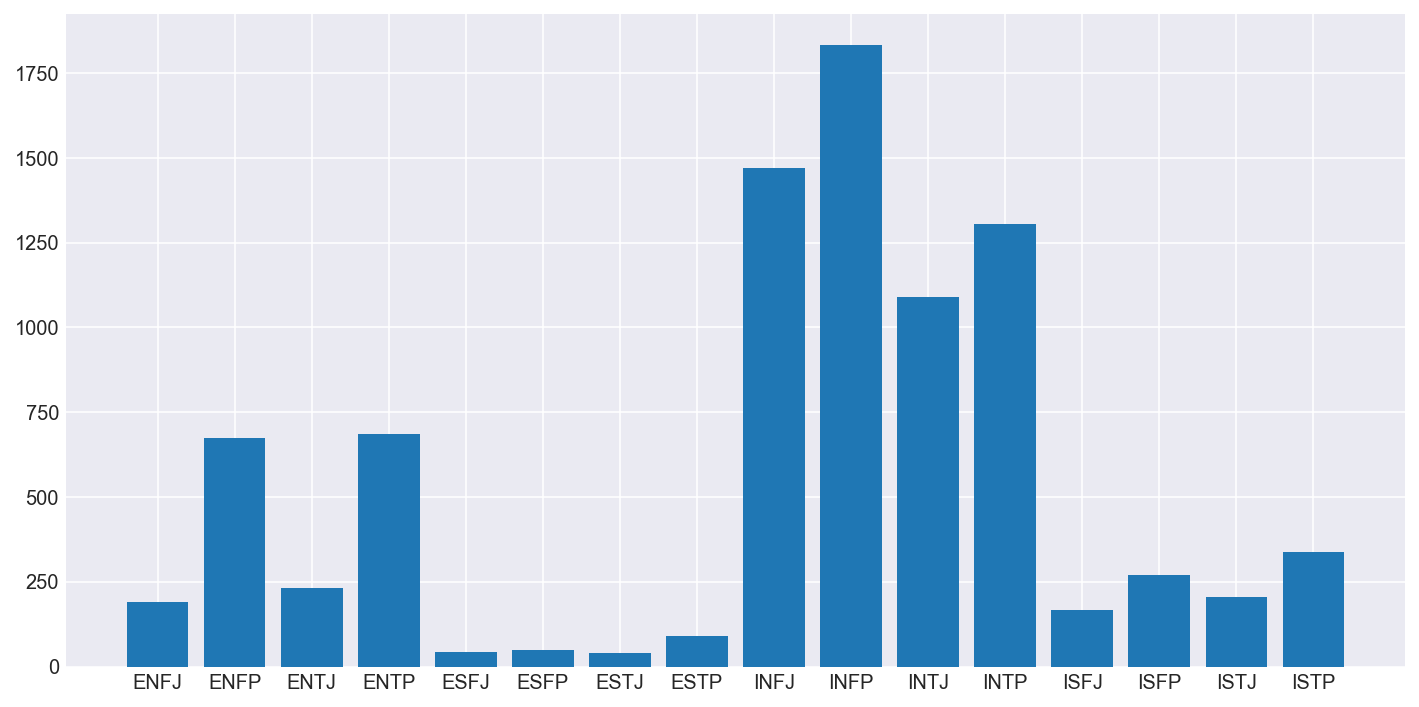

In [197]:
#Cast it here
mbtitypes = mbtitypes_all['type'].value_counts()
plt.figure(figsize=(12,6))
plt.bar(mbtitypes.index, mbtitypes)

In [209]:
#Representation compared to general population
#Here's a dictionary. Good luck to me.
#Source: https://www.careerplanner.com/MB2/TypeInPopulation.cfm

mbtipopdict = {'ISFJ':13.8, 'ESFJ':12.3, 'ISTJ':11.6, 'ISFP':8.8, 'ESTJ':8.7,'ESFP':8.5,'ENFP':8.1,'ISTP':5.4,'INFP':4.4,
              'ESTP':4.3,'INTP':3.3,'ENTP':3.2,'ENFJ':2.5,'INTJ':2.1,'ENTJ':1.8,'INFJ':1.5}
mbtipopdf = pd.DataFrame(data=mbtipopdict.values(), index=mbtipopdict.keys(), columns=['percentage'])
mbtipopdf.sort_values('percentage', ascending=False)

,percentage
ISFJ,13.8
ESFJ,12.3
ISTJ,11.6
ISFP,8.8
ESTJ,8.7
ESFP,8.5
ENFP,8.1
ISTP,5.4
INFP,4.4
ESTP,4.3


In [210]:
mbtipopdf = mbtipopdf.join(mbtitypes)

In [211]:
mbtipopdf['perc_scale'] = mbtipopdf['percentage'] * (mbti.shape[0]/100)
mbtipopdf.head()

,percentage,type,perc_scale
ENFJ,2.5,190,215.0
ESFP,8.5,48,731.0
INFJ,1.5,1470,129.0
ISTJ,11.6,205,997.6
ENTJ,1.8,231,154.8


In [213]:
mbtipopdf = mbtipopdf.sort_values('type', ascending=False).reset_index()
mbtipopdf.rename(columns={'index':'MBTI'}, inplace=True)

In [222]:
mbtipopdf.head()

,MBTI,percentage,type,perc_scale
0,INFP,4.4,1832,378.4
1,INFJ,1.5,1470,129.0
2,INTP,3.3,1304,283.8
3,INTJ,2.1,1091,180.6
4,ENTP,3.2,685,275.2


[Text(0,0,u'INFP'),
 Text(0,0,u'INFJ'),
 Text(0,0,u'INTP'),
 Text(0,0,u'INTJ'),
 Text(0,0,u'ENTP'),
 Text(0,0,u'ENFP'),
 Text(0,0,u'ISTP'),
 Text(0,0,u'ISFP'),
 Text(0,0,u'ENTJ'),
 Text(0,0,u'ISTJ'),
 Text(0,0,u'ENFJ'),
 Text(0,0,u'ISFJ'),
 Text(0,0,u'ESTP'),
 Text(0,0,u'ESFP'),
 Text(0,0,u'ESFJ'),
 Text(0,0,u'ESTJ')]

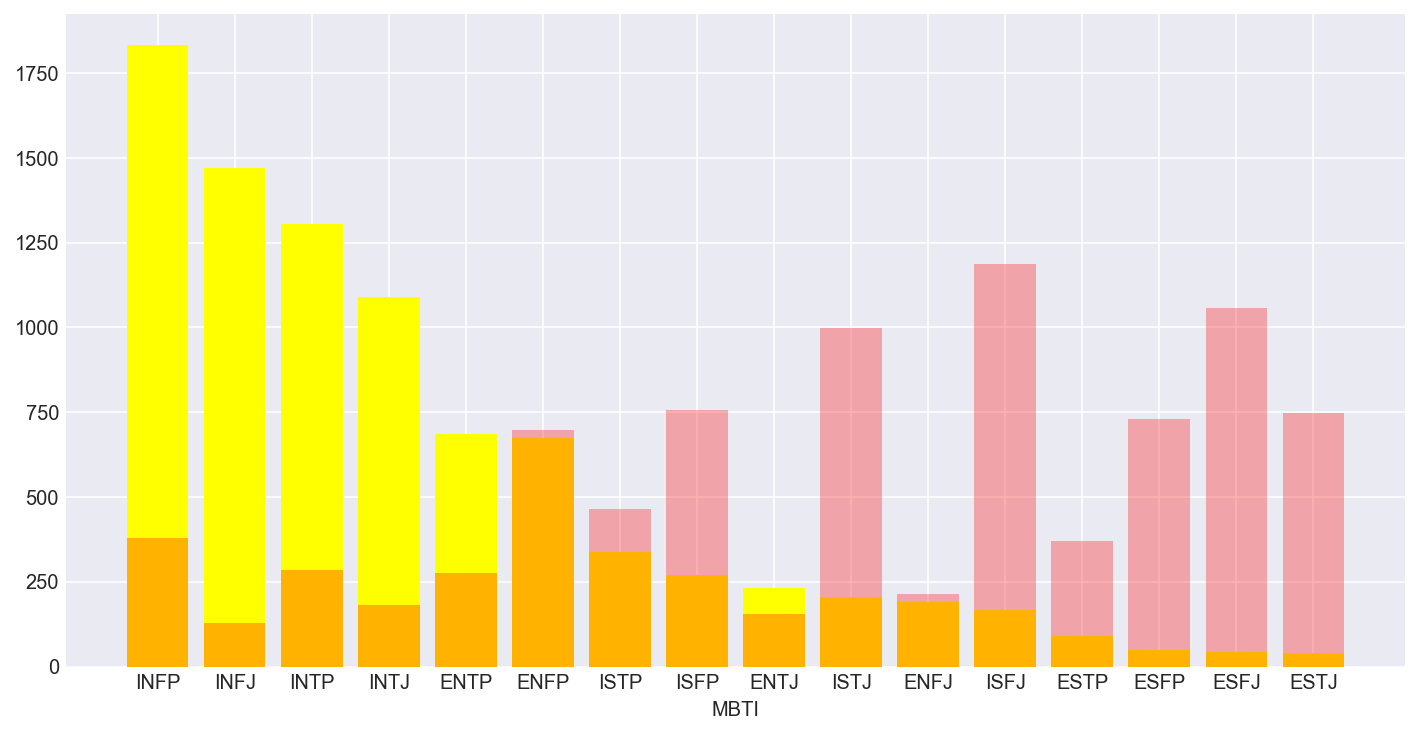

In [221]:
plt.figure(figsize=(12,6))
plt.bar(mbtipopdf.index, mbtipopdf['type'], color='yellow')
plt.bar(mbtipopdf.index, mbtipopdf['perc_scale'], color='red', alpha=0.3)
plt.xlabel('MBTI')
plt.title('Proportion of MBTI types in forum in comparison to general population representation')
ax = plt.gca() # grab the current axis
ax.set_xticks(mbtipopdf.index) # choose which x locations to have ticks
ax.set_xticklabels(mbtipopdf['MBTI']) # set the labels to display at those ticks

Time to unleash imblearn!

In [ ]:
from imblearn

View each type individually

In [146]:
mbtitypes_all['is_E'] = mbtitypes_all['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
mbtitypes_all['is_S'] = mbtitypes_all['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
mbtitypes_all['is_T'] = mbtitypes_all['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
mbtitypes_all['is_J'] = mbtitypes_all['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
mbtitypes_all.columns = ['type','is_E','is_S','is_T','is_J']
mbtitypes_all.head()

,type,is_E,is_S,is_T,is_J
0,INFJ,0,0,0,1
1,ENTP,1,0,1,0
2,INTP,0,0,1,0
3,INTJ,0,0,1,1
4,ENTJ,1,0,1,1


In [151]:
ESTJstat = mbtitypes_all.iloc[:,1:].apply(np.sum, axis=0)
ESTJstat

is_E    1999
is_S    1197
is_T    3981
is_J    3434
dtype: int64

([<matplotlib.patches.Wedge at 0x24267e10>,
 [Text(0.353528,1.04164,u'J'), Text(-0.353528,-1.04164,u'P')])

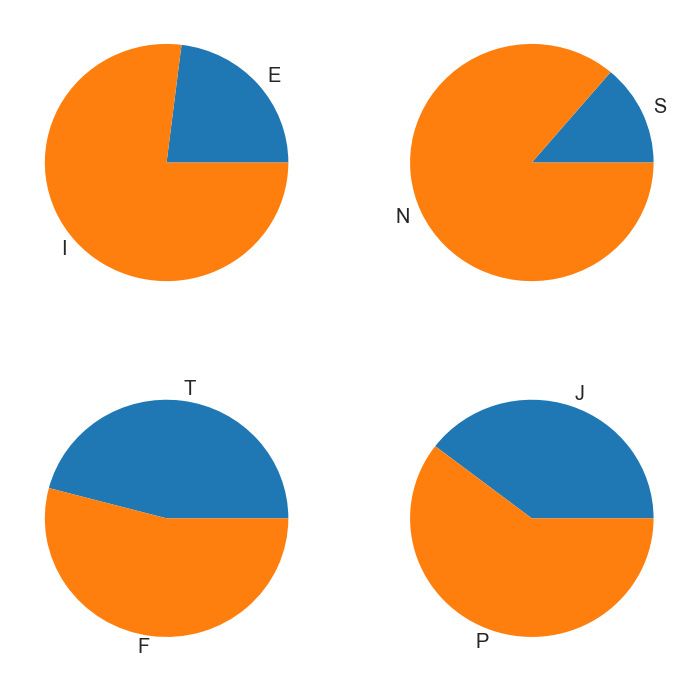

In [156]:
totalno = mbti.shape[0]
ESTJstat[0]
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.pie([ESTJstat[0], totalno-ESTJstat[0]], labels=['E','I'])
plt.subplot(222)
plt.pie([ESTJstat[1], totalno-ESTJstat[1]], labels=['S','N'])
plt.subplot(223)
plt.pie([ESTJstat[2], totalno-ESTJstat[2]], labels=['T','F'])
plt.subplot(224)
plt.pie([ESTJstat[3], totalno-ESTJstat[3]], labels=['J','P'])